In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from IPython.core.display import display

pd.set_option('display.max_columns', None)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import utils_attributes_analysis
import utils

## Table of contents:
* [Dataset setup and description](#dataset)
* [Notebook setup](#notebook_setup)
* [Dataset cleaning](#dataset_cleaning)
* [Discretization of chunk numerical columns](#discretization)
* [Chunk attributes](#chunk)
    * [Distribution of chunk categorical attributes](#chunk_categorical_distribution)
    * [Distribution of chunk continuous attributes](#chunk_continuous_distribution)
    * [Distribution of chunk continuous attributes per developerdecision](#chunk_continuous_decision)
    * [Correlation between chunk continuous attributes and developerdecision](#correlation_chunk)
    * [Probability plots for chunk continuous attributes](#chunk_probability)
    * [Lift analysis for Chunk level attributes](#chunk_lift)
* [File attributes](#file)
    * [Distribution of file categorical attributes](#file_categorical_distribution)
    * [Lift analysis for File level attributes](#file_lift)
* [Merge attributes](#merge)
    * [Distribution of merge categorical attributes](#merge_categorical_distribution)
    * [Lift analysis for Merge level attributes](#merge_lift)

### Dataset setup and description <a class="anchor" id="dataset"></a>

In [2]:
df = pd.read_csv("../../data/dataset-training.csv")
df.head()

,chunk_id,developerdecision,line_start,line_end,line_separator,kind_conflict,url,project,project_user,project_name,path,file_name,sha,leftsha,rightsha,basesha,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkRelSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_left_rel_size,chunk_right_abs_size,chunk_right_rel_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection,self_conflict_perc,has_branch_merge_message_indicator,has_multiple_devs_on_each_side,If statement,Enum signature,Package declaration,Break statement,Import,Enum value,Annotation,Throw statement,Annotation declaration,Class signature,Try statement,TypeDeclarationStatement,Comment,Assert statement,Class declaration,Cast expression,Array access,Enum declaration,For statement,Method invocation,Return statement,Interface signature,Variable,Method interface,Case statement,Interface declaration,Continue statement,While statement,Synchronized statement,Method signature,Other,Blank,Array initializer,Switch statement,Static initializer,Do statement,Method declaration,Attribute,Catch clause
0,780020,Manual,171,257,207,"Case statement, Comment, For statement, Method...",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/FactA...,FactAdder.java,9219deb426f35f7409a6eb6185c6486b5da4e6fe,a100b1d71caaa176474e7a630972f6679660d8da,961ff4fc69295b67ca9e94c86d334834f6c15020,fee6dbeac4d90fae3b701e3544c6e576aacdb5b2,9.0,106.0,3073.0,3610.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,2.0,3.0,4.0,15.0,84.0,0.269231,3.0,312.0,35.0,0.416667,49.0,0.583333,4.121782,4.432338,1.0,1.0,2.0,0.0,0.0,13.0,1.0,39.0,4.0,1.0,0.333333,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,780349,Manual,103,118,112,"Attribute, Comment",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/AnkiD...,AnkiDroid.java,24d026e6424e9df66bd8755ec5c6f82fcea65c8b,aed3df5e3adb552ad6c967ee3cc906bd7f2880ff,2093128dcbaaa74a1972cf806870804e3025c8b5,f112e09e4019f812e11bf8721f8638f96207b180,3655.0,5911.0,1528.0,16812.0,0.0,32.0,18.0,1.0,4.0,0.0,2.0,12.0,19.0,5.0,17.0,3.0,12.0,1.0,1.0,171.0,13.0,0.007715,1.0,1685.0,8.0,0.615385,5.0,0.384615,115.110104,116.961458,3.0,8.0,11.0,1.0,1.0,65.0,67.0,79.0,74.0,1.0,0.333333,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,778509,Version 2,267,307,282,"Comment, If statement, Method invocation, Vari...",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/DeckT...,DeckTask.java,172c065f8ec739f660ac6bc4f21a6103b25a2464,c4e1eac57e1fbbf6222ca91d5be01988f6d02c67,8d7fa2935ffa1dba599d401d9544e0afd6e412f2,b48348fdc1933b63855c72a10bd44a59453c022c,15125.0,40397.0,9860.0,8411.0,108.0,115.0,28.0,7.0,13.0,1.0,3.0,14.0,79.0,12.0,23.0,9.0,25.0,4.0,8.0,94.0,38.0,0.037811,2.0,1005.0,14.0,0.368421,24.0,0.631579,114.542928,116.028727,1.0,11.0,12.0,1.0,1.0,28.0,526.0,68.0,889.0,1.0,0.166667,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,778739,Combination,39,47,44,Import,https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/CardE...,CardEditor.java,f939a01b341a6a09a4bf6b1b25fc2275c74636a8,a7b7898292bc2ab73502b829568e176d30fc32d8,16011759134702ff0bb04dd5cd65d579ef36f064,df907cb0e4722e67316d5eb48ec2f7551660d0e2,973.0,2265.0,10742.0,8776.0,5.0,12.0,3.0,1.0,0.0,0.0,0.0,2.0,14.0,3.0,11.0,0.0,15.0,1.0,1.0,62.0,6.0,0.009317,1.0,644.0,4.0

In [3]:
total_chunks = len(df)
total_projects = len(pd.unique(df['project']))
total_merges = len(pd.unique(df['sha']))
print(f"The dataset has {total_merges} merges with {total_chunks} chunks from {total_projects} projects.")

The dataset has 4316 merges with 56241 chunks from 29 projects.


In [4]:
df.describe()

,chunk_id,line_start,line_end,line_separator,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkRelSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_left_rel_size,chunk_right_abs_size,chunk_right_rel_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection,self_conflict_perc,has_branch_merge_message_indicator,has_multiple_devs_on_each_side,If statement,Enum signature,Package declaration,Break statement,Import,Enum value,Annotation,Throw statement,Annotation declaration,Class signature,Try statement,TypeDeclarationStatement,Comment,Assert statement,Class declaration,Cast expression,Array access,Enum declaration,For statement,Method invocation,Return statement,Interface signature,Variable,Method interface,Case statement,Interface declaration,Continue statement,While statement,Synchronized statement,Method signature,Other,Blank,Array initializer,Switch statement,Static initializer,Do statement,Method declaration,Attribute,Catch clause
count,5.624100e+04,56241.000000,56241.000000,56241.000000,56241.000000,5.624100e+04,5.624100e+04,5.624100e+04,53611.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,42644.000000,50901.000000,50901.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.00000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000
mean,1.162030e+06,8470.753489,8498.274853,8481.438595,3628.796056,4.768173e+04,6.254152e+04,1.187983e+05,8.309750,406.560303,207.740794,11.904714,26.208282,22.657421,19.429704,91.980370,312.433278,106.998471,183.841361,16.187906,506.544816,2.300060,3.806345,1643.686269,25.695557,0.038855,2.406931,15699.612951,9.537060,0.493898,16.158497,0.505990,58.546401,59.682937,37.034931,3.736017,40.770948,2.194810,0.856329,708.488045,160.554488,1740.774543,485.382586,0.980904,0.525975,0.553133,0.298226,0.214559,0.000356,0.009868,0.010508,0.089134,0.001671,0.052844,0.007948,0.000071,0.014705,0.02155,0.000338,0.358582,0.001903,0.013371,0.026262,0.006952,0.000729,0.022741,0.405078,0.052044,0.001102,0.202628,0.014669,0.018190,0.001671,0.000391,0.005352,0.008908,0.108551,0.015505,0.016305,0.002311,0.011113,0.002436,0.002934,0.089863,0.187479,0.008659
std,2.233468e+05,21033.525641,21029.124596,21032.067176,13981.484314,3.111554e+05,2.679819e+05,2.748542e+05,20.846991,862.008678,549.942471,26.010594,49.993931,49.195670,37.564834,216.172037,629.757917,207.782047,373.038221,31.648065,1303.049597,9.429353,24.093358,3264.323036,207.670106,0.108744,1.137982,34392.059789,92.780977,0.251875,132.010018,0.251877,213.737401,214.137207,63.356058,6.430939,63.269015,4.553917,0.413247,1177.529274,590.657343,1833.755662,786.425113,0.139986,0.444083,0.497174,0.457484,0.410520,0.018855,0.098849,0.101971,0.284940,0.040849,0.223724,0.088797,0.008433,0.120369,0.14521,0.018377,0.479588,0.043577,0.114859,0.159915,0.083090,0.026990,0.149079,0.490912,0.222118,0.033184,0

### Notebook setup <a class="anchor" id="notebook_setup"></a>

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = list(df.select_dtypes(include=numerics))
not_attributes_columns = ['chunk_id', 'line_start', 'line_end', 'line_separator']
float_columns = ['chunkRelSize','self_conflict_perc','chunk_left_rel_size', 'chunk_right_rel_size']
numeric_columns = [elem for elem in numeric_columns if elem not in not_attributes_columns]
numeric_columns = [elem for elem in numeric_columns if elem not in float_columns]
last_not_boolean_column = "self_conflict_perc"
last_not_boolean_column_index = list(df.columns).index(last_not_boolean_column)
boolean_columns = list(df.columns)[last_not_boolean_column_index+1:]
numeric_columns = [elem for elem in numeric_columns if elem not in boolean_columns]
print(f"Numeric columns: ", numeric_columns)

chunk_columns_categorical = ['leftCC', 'rightCC', 'chunkAbsSize', 'chunk_left_abs_size', 'chunk_right_abs_size' ]
chunk_columns_float = ['chunkRelSize', 'self_conflict_perc', 'chunk_left_rel_size', 'chunk_right_rel_size', 'chunkPosition' ]


file_columns_categorical = ['fileCC', 'fileSize']
# file_columns_float = []

merge_columns_categorical = ['left_lines_added', 'left_lines_removed', 'right_lines_added', 'right_lines_removed', 'conclusion_delay']
merge_columns_categorical.extend(['keyword_fix', 'keyword_bug', 'keyword_feature', 'keyword_improve', 'keyword_document'])
merge_columns_categorical.extend(['keyword_refactor', 'keyword_update','keyword_add', 'keyword_remove', 'keyword_use'])
merge_columns_categorical.extend(['keyword_delete', 'keyword_change', 'Branching time', 'Merge isolation time', 'Devs 1', 'Devs 2'])
merge_columns_categorical.extend(['Different devs', 'Same devs', 'Devs intersection', 'Commits 1', 'Commits 2'])
merge_columns_categorical.extend(['Changed files 1','Changed files 2', 'Changed files intersection'])

Numeric columns:  ['left_lines_added', 'left_lines_removed', 'right_lines_added', 'right_lines_removed', 'conclusion_delay', 'keyword_fix', 'keyword_bug', 'keyword_feature', 'keyword_improve', 'keyword_document', 'keyword_refactor', 'keyword_update', 'keyword_add', 'keyword_remove', 'keyword_use', 'keyword_delete', 'keyword_change', 'leftCC', 'rightCC', 'fileCC', 'chunkAbsSize', 'chunkPosition', 'fileSize', 'chunk_left_abs_size', 'chunk_right_abs_size', 'Branching time', 'Merge isolation time', 'Devs 1', 'Devs 2', 'Different devs', 'Same devs', 'Devs intersection', 'Commits 1', 'Commits 2', 'Changed files 1', 'Changed files 2', 'Changed files intersection']


### Dataset cleaning <a class="anchor" id="dataset_cleaning"></a>

In [6]:
for column in numeric_columns:
#     print(column)
    if df[column].min() < 0:
        df = df[(df[column] >= 0) | (df[column].isna())]
df = df[df['developerdecision']!='UnknownConcatenation']
df.head()

,chunk_id,developerdecision,line_start,line_end,line_separator,kind_conflict,url,project,project_user,project_name,path,file_name,sha,leftsha,rightsha,basesha,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkRelSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_left_rel_size,chunk_right_abs_size,chunk_right_rel_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection,self_conflict_perc,has_branch_merge_message_indicator,has_multiple_devs_on_each_side,If statement,Enum signature,Package declaration,Break statement,Import,Enum value,Annotation,Throw statement,Annotation declaration,Class signature,Try statement,TypeDeclarationStatement,Comment,Assert statement,Class declaration,Cast expression,Array access,Enum declaration,For statement,Method invocation,Return statement,Interface signature,Variable,Method interface,Case statement,Interface declaration,Continue statement,While statement,Synchronized statement,Method signature,Other,Blank,Array initializer,Switch statement,Static initializer,Do statement,Method declaration,Attribute,Catch clause
0,780020,Manual,171,257,207,"Case statement, Comment, For statement, Method...",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/FactA...,FactAdder.java,9219deb426f35f7409a6eb6185c6486b5da4e6fe,a100b1d71caaa176474e7a630972f6679660d8da,961ff4fc69295b67ca9e94c86d334834f6c15020,fee6dbeac4d90fae3b701e3544c6e576aacdb5b2,9.0,106.0,3073.0,3610.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,2.0,3.0,4.0,15.0,84.0,0.269231,3.0,312.0,35.0,0.416667,49.0,0.583333,4.121782,4.432338,1.0,1.0,2.0,0.0,0.0,13.0,1.0,39.0,4.0,1.0,0.333333,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,780349,Manual,103,118,112,"Attribute, Comment",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/AnkiD...,AnkiDroid.java,24d026e6424e9df66bd8755ec5c6f82fcea65c8b,aed3df5e3adb552ad6c967ee3cc906bd7f2880ff,2093128dcbaaa74a1972cf806870804e3025c8b5,f112e09e4019f812e11bf8721f8638f96207b180,3655.0,5911.0,1528.0,16812.0,0.0,32.0,18.0,1.0,4.0,0.0,2.0,12.0,19.0,5.0,17.0,3.0,12.0,1.0,1.0,171.0,13.0,0.007715,1.0,1685.0,8.0,0.615385,5.0,0.384615,115.110104,116.961458,3.0,8.0,11.0,1.0,1.0,65.0,67.0,79.0,74.0,1.0,0.333333,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,778509,Version 2,267,307,282,"Comment, If statement, Method invocation, Vari...",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/DeckT...,DeckTask.java,172c065f8ec739f660ac6bc4f21a6103b25a2464,c4e1eac57e1fbbf6222ca91d5be01988f6d02c67,8d7fa2935ffa1dba599d401d9544e0afd6e412f2,b48348fdc1933b63855c72a10bd44a59453c022c,15125.0,40397.0,9860.0,8411.0,108.0,115.0,28.0,7.0,13.0,1.0,3.0,14.0,79.0,12.0,23.0,9.0,25.0,4.0,8.0,94.0,38.0,0.037811,2.0,1005.0,14.0,0.368421,24.0,0.631579,114.542928,116.028727,1.0,11.0,12.0,1.0,1.0,28.0,526.0,68.0,889.0,1.0,0.166667,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,778739,Combination,39,47,44,Import,https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/CardE...,CardEditor.java,f939a01b341a6a09a4bf6b1b25fc2275c74636a8,a7b7898292bc2ab73502b829568e176d30fc32d8,16011759134702ff0bb04dd5cd65d579ef36f064,df907cb0e4722e67316d5eb48ec2f7551660d0e2,973.0,2265.0,10742.0,8776.0,5.0,12.0,3.0,1.0,0.0,0.0,0.0,2.0,14.0,3.0,11.0,0.0,15.0,1.0,1.0,62.0,6.0,0.009317,1.0,644.0,4.0

In [7]:
total_chunks = len(df)
total_projects = len(pd.unique(df['project']))
total_merges = len(pd.unique(df['sha']))
print(f"The dataset has {total_merges} merges with {total_chunks} chunks from {total_projects} projects.")

The dataset has 4315 merges with 56240 chunks from 29 projects.


In [8]:
df.describe()

,chunk_id,line_start,line_end,line_separator,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkRelSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_left_rel_size,chunk_right_abs_size,chunk_right_rel_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection,self_conflict_perc,has_branch_merge_message_indicator,has_multiple_devs_on_each_side,If statement,Enum signature,Package declaration,Break statement,Import,Enum value,Annotation,Throw statement,Annotation declaration,Class signature,Try statement,TypeDeclarationStatement,Comment,Assert statement,Class declaration,Cast expression,Array access,Enum declaration,For statement,Method invocation,Return statement,Interface signature,Variable,Method interface,Case statement,Interface declaration,Continue statement,While statement,Synchronized statement,Method signature,Other,Blank,Array initializer,Switch statement,Static initializer,Do statement,Method declaration,Attribute,Catch clause
count,5.624000e+04,56240.000000,56240.000000,56240.000000,56240.00000,5.624000e+04,5.624000e+04,5.624000e+04,53610.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,53615.000000,53615.000000,53615.000000,53615.000000,53615.000000,53615.000000,53615.000000,53615.000000,53615.000000,53615.000000,53615.000000,50900.000000,50900.000000,50900.000000,50900.000000,50900.000000,50900.000000,50900.000000,50900.000000,50900.000000,50900.000000,50900.000000,50900.000000,42643.000000,50900.000000,50900.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000,56240.000000
mean,1.162036e+06,8470.899662,8498.421284,8481.584815,3628.85978,4.768257e+04,6.254257e+04,1.188003e+05,8.309905,406.566518,207.743563,11.904925,26.208730,22.657770,19.430050,91.981650,312.437482,107.000036,183.844061,16.188122,506.551760,2.300065,3.806397,1643.713979,25.695831,0.038856,2.406957,15699.882384,9.537107,0.493896,16.158724,0.505992,58.547526,59.684111,37.034578,3.736071,40.770648,2.194853,0.856346,708.499784,160.557623,1740.801218,485.392063,0.980904,0.525976,0.553143,0.298232,0.214545,0.000356,0.009868,0.010509,0.089136,0.001671,0.052845,0.007948,0.000071,0.014705,0.021550,0.000338,0.358588,0.001903,0.013371,0.026262,0.006952,0.000729,0.022742,0.405068,0.052045,0.001102,0.202614,0.014669,0.018190,0.001671,0.000391,0.005352,0.008908,0.108535,0.015505,0.016305,0.002312,0.011113,0.002436,0.002934,0.089865,0.187482,0.008659
std,2.233443e+05,21033.684075,21029.282884,21032.225577,13981.60045,3.111581e+05,2.679842e+05,2.748562e+05,20.847154,862.015082,549.946968,26.010777,49.994262,49.196037,37.565079,216.173746,629.762727,207.783563,373.040988,31.648305,1303.060141,9.429441,24.093580,3264.347172,207.672033,0.108745,1.137976,34392.323939,92.781841,0.251876,132.011239,0.251879,213.739350,214.139146,63.356630,6.430990,63.269601,4.553951,0.413233,1177.537863,590.662722,1833.763800,786.429932,0.139987,0.444088,0.497173,0.457486,0.410510,0.018855,0.098849,0.101972,0.284942,0.040849,0.223726,0.088798,0.008433,0.120370,0.145212,0.018377,0.479590,0.043577,0.114860,0.159916,0.083091,0.026991,0.149081,0.490909,0.222119,0.033185,0

### Discretization of chunk numerical columns <a class="anchor" id="discretization"></a>

In [9]:
discretized, labels = utils.get_discretized_df(df, numeric_columns)
discretized

,chunk_id,developerdecision,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_right_abs_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection
0,780020,Manual,Few (<10),Hundreds,Thousands,Thousands,Zero,Few (<10),Few (<10),Zero,Zero,Zero,Zero,Zero,Few (<10),Zero,Few (<10),Zero,Few (<10),Few (<10),Few (<10),Tens,Tens,Few (<10),Hundreds,Tens,Tens,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Zero,Zero,Tens,Few (<10),Tens,Few (<10),Few (<10)
1,780349,Manual,Thousands,Thousands,Thousands,Tens of thousands,Zero,Tens,Tens,Few (<10),Few (<10),Zero,Few (<10),Tens,Tens,Few (<10),Tens,Few (<10),Tens,Few (<10),Few (<10),Hundreds,Tens,Few (<10),Thousands,Few (<10),Few (<10),Hundreds,Hundreds,Few (<10),Few (<10),Tens,Few (<10),Few (<10),Tens,Tens,Tens,Tens,Few (<10)
2,778509,Version 2,Tens of thousands,Tens of thousands,Thousands,Thousands,Hundreds,Hundreds,Tens,Few (<10),Tens,Few (<10),Few (<10),Tens,Tens,Tens,Tens,Few (<10),Tens,Few (<10),Few (<10),Tens,Tens,Few (<10),Thousands,Tens,Tens,Hundreds,Hundreds,Few (<10),Tens,Tens,Few (<10),Few (<10),Tens,Hundreds,Tens,Hundreds,Few (<10)
3,778739,Combination,Hundreds,Thousands,Tens of thousands,Thousands,Few (<10),Tens,Few (<10),Few (<10),Zero,Zero,Zero,Few (<10),Tens,Few (<10),Tens,Zero,Tens,Few (<10),Few (<10),Tens,Few (<10),Few (<10),Hundreds,Few (<10),Few (<10),Tens,Tens,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Tens,Tens,Tens,Tens,Few (<10)
4,780250,Version 2,Tens,Hundreds,Tens,Tens,Zero,Zero,Zero,Zero,Zero,Zero,Few (<10),Zero,Zero,Zero,Zero,Zero,Few (<10),Few (<10),Zero,Hundreds,Tens,Few (<10),Thousands,Tens,Zero,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Zero,Zero,Few (<10),Few (<10),Few (<10),Tens,Few (<10)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56236,1657774,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Tens,Tens,Tens,Tens,Hundreds,Hundreds,Hundreds,Hundreds,Tens,Thousands,Few (<10),Zero,Tens,Few (<10),Few (<10),Hundreds,Few (<10),Zero,Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Thousands,Few (<10),Thousands,Thousands,Few (<10)
56237,1657854,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Tens,Tens,Tens,Tens,Hundreds,Hundreds,Hundreds,Hundreds,Tens,Thousands,Few (<10),Zero,Hundreds,Few (<10),Few (<10),Hundreds,Few (<10),Zero,Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Thousands,Few (<10),Thousands,Thousands,Few (<10)
56238,1656283,Combination,Tens,Tens,Tens of thousands,Hundreds of thousands,Zero,Hundreds,Hundreds,Tens,Tens,Tens,Tens,Hundreds,Hundreds,Hundreds,Hundreds,Tens,Thousands,Few (<10),Zero,Hundreds,Tens,Few (<10),Hundreds,Tens,Zero,Few (<10),Few (<10),Hundreds,Few (<10),Hundreds,Zero,Zero,Thousands,Few (<10),Thousands,Few (<10),Few (<10)
56239,1657886,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Tens,Tens,Tens,Tens,Hundreds,Hundreds,Hundreds,Hundreds,Tens,Thousands,Few (<10),Zero,Hundreds,Few (<10),Few (<10),Thousands,Few (<10),Zero,Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Thousands,Few (<10),Thousands,Thousands,Few (<10)


In [10]:
discretized_log = utils.get_discretized_df_new(df, numeric_columns)
discretized_log

,chunk_id,developerdecision,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_right_abs_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection
0,780020,Manual,3,7,12,12,-1,1,1,-1,-1,-1,-1,-1,2,-1,2,-1,1,2,2,4,6,2,8,5,6,2,2,0,0,1,-1,-1,4,0,5,2,0
1,780349,Manual,12,13,11,14,-1,5,4,0,2,-1,1,4,4,2,4,2,4,0,0,7,4,0,11,3,2,7,7,2,3,3,0,0,6,6,6,6,0
2,778509,Version 2,14,15,13,13,7,7,5,3,4,0,2,4,6,4,5,3,5,2,3,7,5,1,10,4,5,7,7,0,3,4,0,0,5,9,6,10,0
3,778739,Combination,10,11,13,13,2,4,2,0,-1,-1,-1,1,4,2,3,-1,4,0,0,6,3,0,9,2,1,6,6,0,3,3,0,0,4,6,6,6,0
4,780250,Version 2,6,7,6,6,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,0,2,-1,7,4,0,10,4,-1,-1,0,0,0,1,-1,-1,0,0,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56236,1657774,Version 1,-1,-1,12,14,-1,9,8,4,5,5,4,7,9,7,9,4,10,0,-1,4,3,2,9,3,-1,6,6,6,0,6,-1,-1,10,0,11,10,0
56237,1657854,Version 1,-1,-1,12,14,-1,9,8,4,5,5,4,7,9,7,9,4,10,0,-1,7,0,2,10,0,-1,6,6,6,0,6,-1,-1,10,0,11,10,0
56238,1656283,Combination,5,5,16,17,-1,10,9,4,6,6,6,8,10,8,8,5,10,3,-1,7,6,1,10,6,-1,0,0,7,0,7,-1,-1,10,0,11,0,0
56239,1657886,Version 1,-1,-1,12,14,-1,9,8,4,5,5,4,7,9,7,9,4,10,0,-1,9,2,0,12,2,-1,6,6,6,0,6,-1,-1,10,0,11,10,0


## Chunk attributes  <a class="anchor" id="chunk"></a>

### Distribution of chunk categorical attributes <a class="anchor" id="chunk_categorical_distribution"></a>

#### Using log2 discretization

In [11]:
discretized_log

,chunk_id,developerdecision,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_right_abs_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection
0,780020,Manual,3,7,12,12,-1,1,1,-1,-1,-1,-1,-1,2,-1,2,-1,1,2,2,4,6,2,8,5,6,2,2,0,0,1,-1,-1,4,0,5,2,0
1,780349,Manual,12,13,11,14,-1,5,4,0,2,-1,1,4,4,2,4,2,4,0,0,7,4,0,11,3,2,7,7,2,3,3,0,0,6,6,6,6,0
2,778509,Version 2,14,15,13,13,7,7,5,3,4,0,2,4,6,4,5,3,5,2,3,7,5,1,10,4,5,7,7,0,3,4,0,0,5,9,6,10,0
3,778739,Combination,10,11,13,13,2,4,2,0,-1,-1,-1,1,4,2,3,-1,4,0,0,6,3,0,9,2,1,6,6,0,3,3,0,0,4,6,6,6,0
4,780250,Version 2,6,7,6,6,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,0,2,-1,7,4,0,10,4,-1,-1,0,0,0,1,-1,-1,0,0,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56236,1657774,Version 1,-1,-1,12,14,-1,9,8,4,5,5,4,7,9,7,9,4,10,0,-1,4,3,2,9,3,-1,6,6,6,0,6,-1,-1,10,0,11,10,0
56237,1657854,Version 1,-1,-1,12,14,-1,9,8,4,5,5,4,7,9,7,9,4,10,0,-1,7,0,2,10,0,-1,6,6,6,0,6,-1,-1,10,0,11,10,0
56238,1656283,Combination,5,5,16,17,-1,10,9,4,6,6,6,8,10,8,8,5,10,3,-1,7,6,1,10,6,-1,0,0,7,0,7,-1,-1,10,0,11,0,0
56239,1657886,Version 1,-1,-1,12,14,-1,9,8,4,5,5,4,7,9,7,9,4,10,0,-1,9,2,0,12,2,-1,6,6,6,0,6,-1,-1,10,0,11,10,0


## Entropy of attributes (with discretization by log2 bin)

In [12]:
# dev_left = discretized_log[['developerdecision','left_lines_added']]

# dev_left

In [13]:
# dev_left[dev_left['left_lines_added'] == 4].groupby(['developerdecision']).count()

In [14]:
# dev_left[dev_left['left_lines_added'] == 4].value_counts(normalize=True)

In [15]:

# dev_left[dev_left['left_lines_added'] == 5]\
#     .value_counts(normalize=True)\
#     .map(lambda x: -1 * x * np.log2(x))\
#     .sum()

In [16]:
# left_entropy = dev_left.groupby('left_lines_added')\
#         .apply(lambda x: x.value_counts(normalize=True)\
#                 .map(lambda x: -1 * x * np.log2(x))\
#                 .sum())\
#         .to_frame(name="entropy")

# left_entropy['entropy'].plot.bar()


Get list of attributes.

Remove *chunk_id* and the target attribute *developerdecision* from the list.

In [17]:
columns_no_label = discretized_log.columns.to_numpy().tolist()

columns_no_label.remove('developerdecision')
columns_no_label.remove('chunk_id')

columns_no_label

['left_lines_added',
 'left_lines_removed',
 'right_lines_added',
 'right_lines_removed',
 'conclusion_delay',
 'keyword_fix',
 'keyword_bug',
 'keyword_feature',
 'keyword_improve',
 'keyword_document',
 'keyword_refactor',
 'keyword_update',
 'keyword_add',
 'keyword_remove',
 'keyword_use',
 'keyword_delete',
 'keyword_change',
 'leftCC',
 'rightCC',
 'fileCC',
 'chunkAbsSize',
 'chunkPosition',
 'fileSize',
 'chunk_left_abs_size',
 'chunk_right_abs_size',
 'Branching time',
 'Merge isolation time',
 'Devs 1',
 'Devs 2',
 'Different devs',
 'Same devs',
 'Devs intersection',
 'Commits 1',
 'Commits 2',
 'Changed files 1',
 'Changed files 2',
 'Changed files intersection']

In [18]:
print(f"We will plot the entropy of {len(columns_no_label)} attributes.")

We will plot the entropy of 37 attributes.


### Entropy plots

Entropy is defined as:

\begin{equation}
E(S) = \sum_{i=1}^n   - p_i \log_2 p_i
\end{equation}

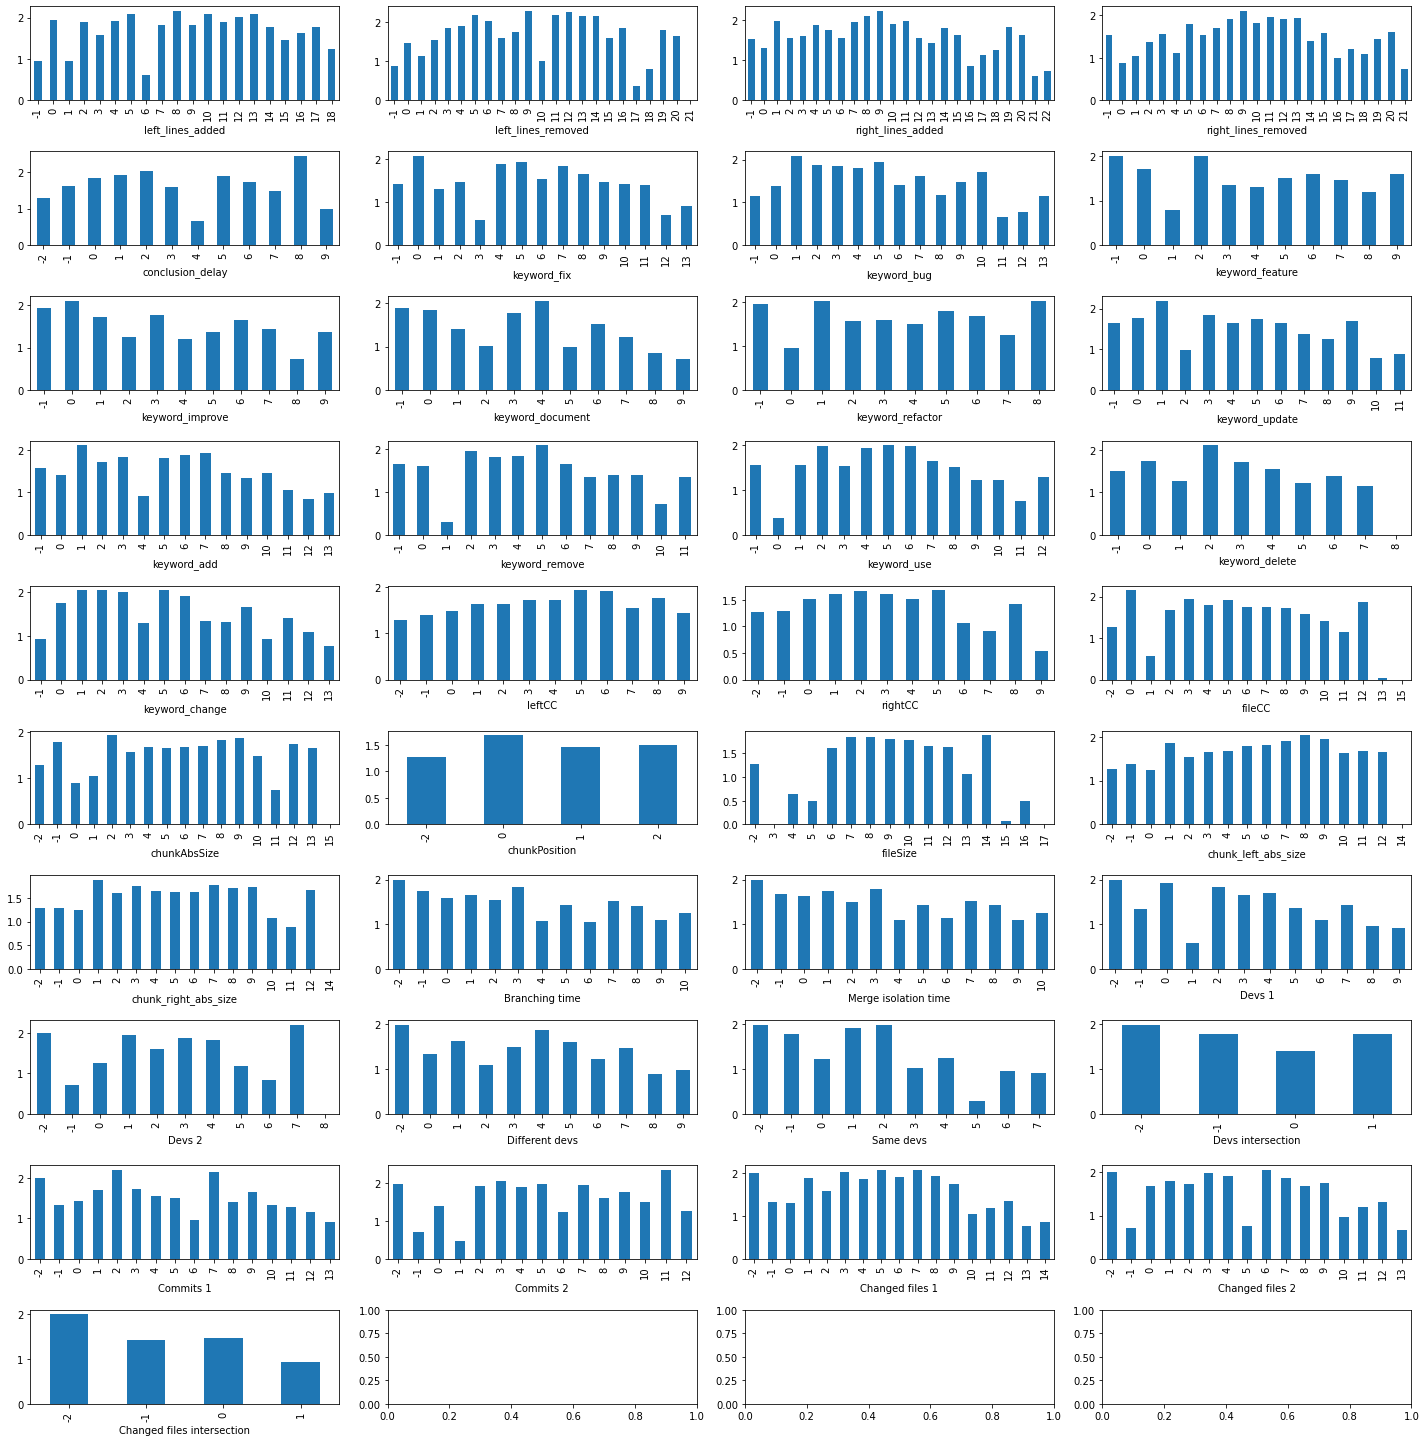

In [19]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(20,20))

fig.tight_layout(h_pad=3, w_pad=1.1)

for i, column in enumerate(columns_no_label):
    df_label_attrib = discretized_log[['developerdecision',column]]

    attr_entropy = utils.entropy(column, discretized_log)

    attr_entropy['entropy'].plot.bar(ax=axes[i // 4, i % 4])
    

### Inspecting the entropy of an attribute

In [20]:
inspected_column = 'rightCC'

In [21]:
inspected_entropy = utils.entropy(inspected_column, discretized_log)

inspected_entropy

,entropy
rightCC,
-2,1.276345
-1,1.288939
0,1.519453
1,1.606668
2,1.670694
3,1.613773
4,1.511880
5,1.680802
6,1.065542


<AxesSubplot:xlabel='rightCC'>

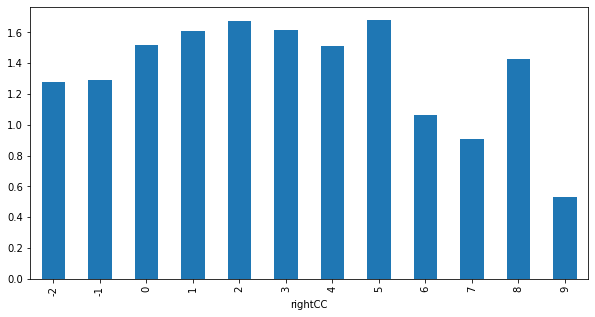

In [22]:
inspected_entropy['entropy'].plot.bar(figsize=(10,5))

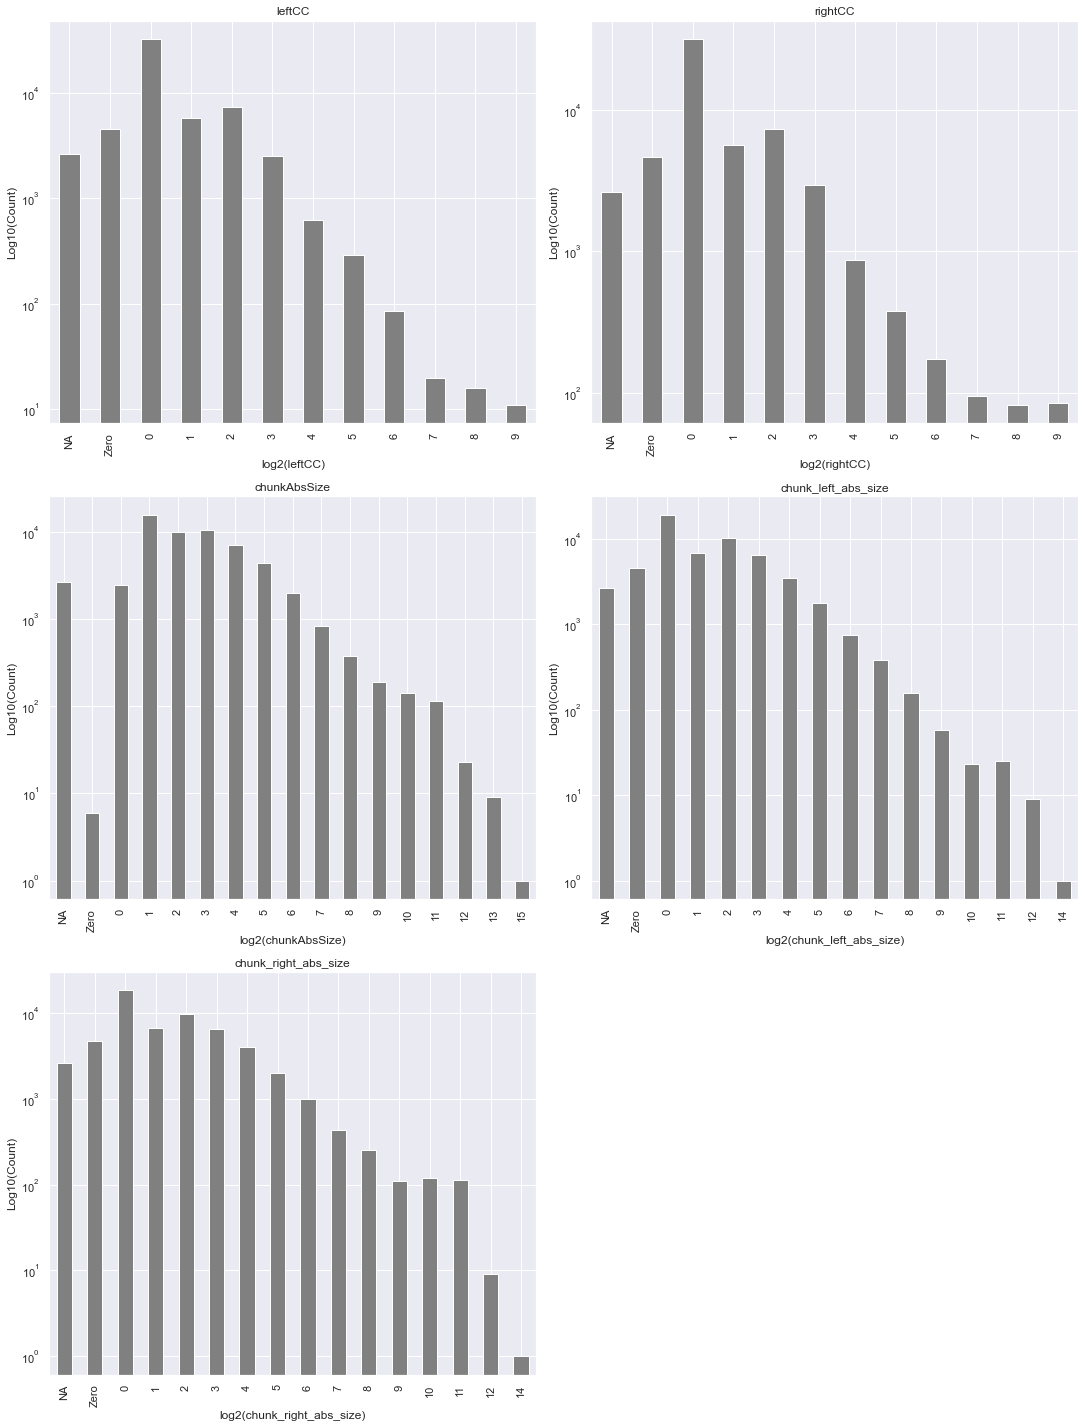

In [23]:
utils_attributes_analysis.count_plot_categorical_new(chunk_columns_categorical, discretized_log, 2, True, 10)

In [24]:
import importlib
importlib.reload(utils_attributes_analysis)

<module 'utils_attributes_analysis' from '/Users/paulo/sandbox2/conflict-resolution-mining/scripts/exploratory_analysis/utils_attributes_analysis.py'>

## Class distribution on attributes

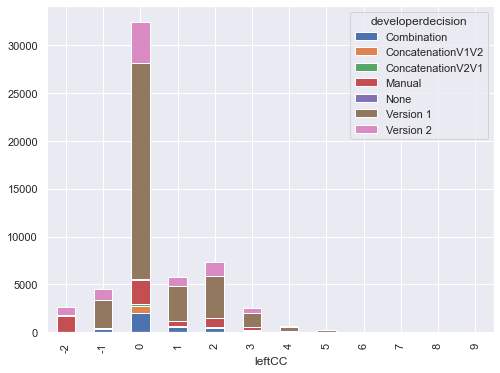

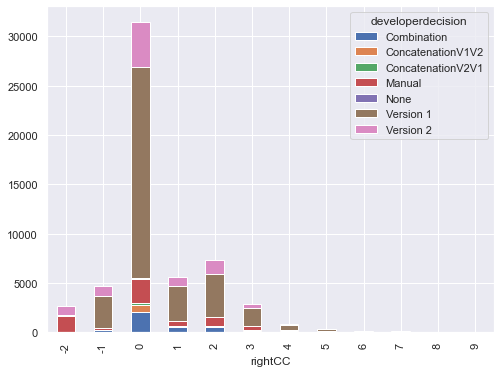

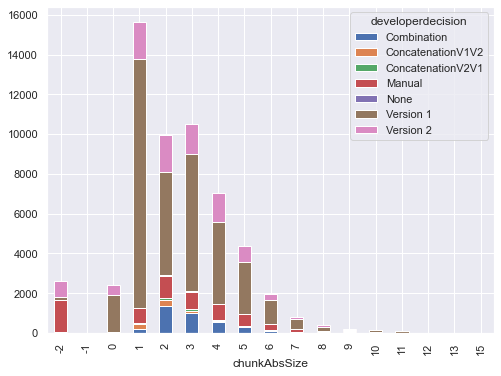

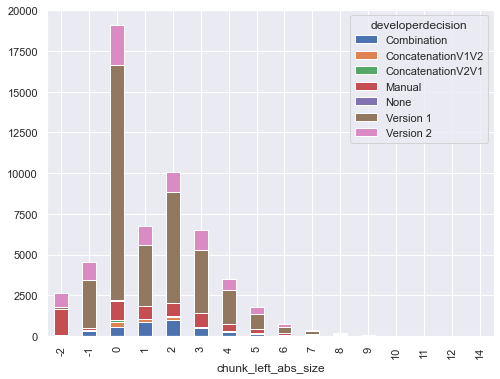

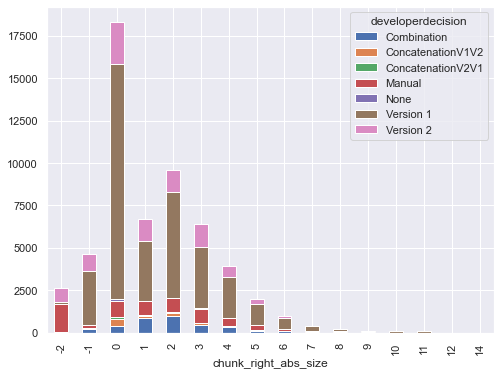

In [25]:
utils_attributes_analysis.count_plot_categorical_stackedbar(chunk_columns_categorical, discretized_log, 3, False, 10)

#### Using log 10 (textual) discretization

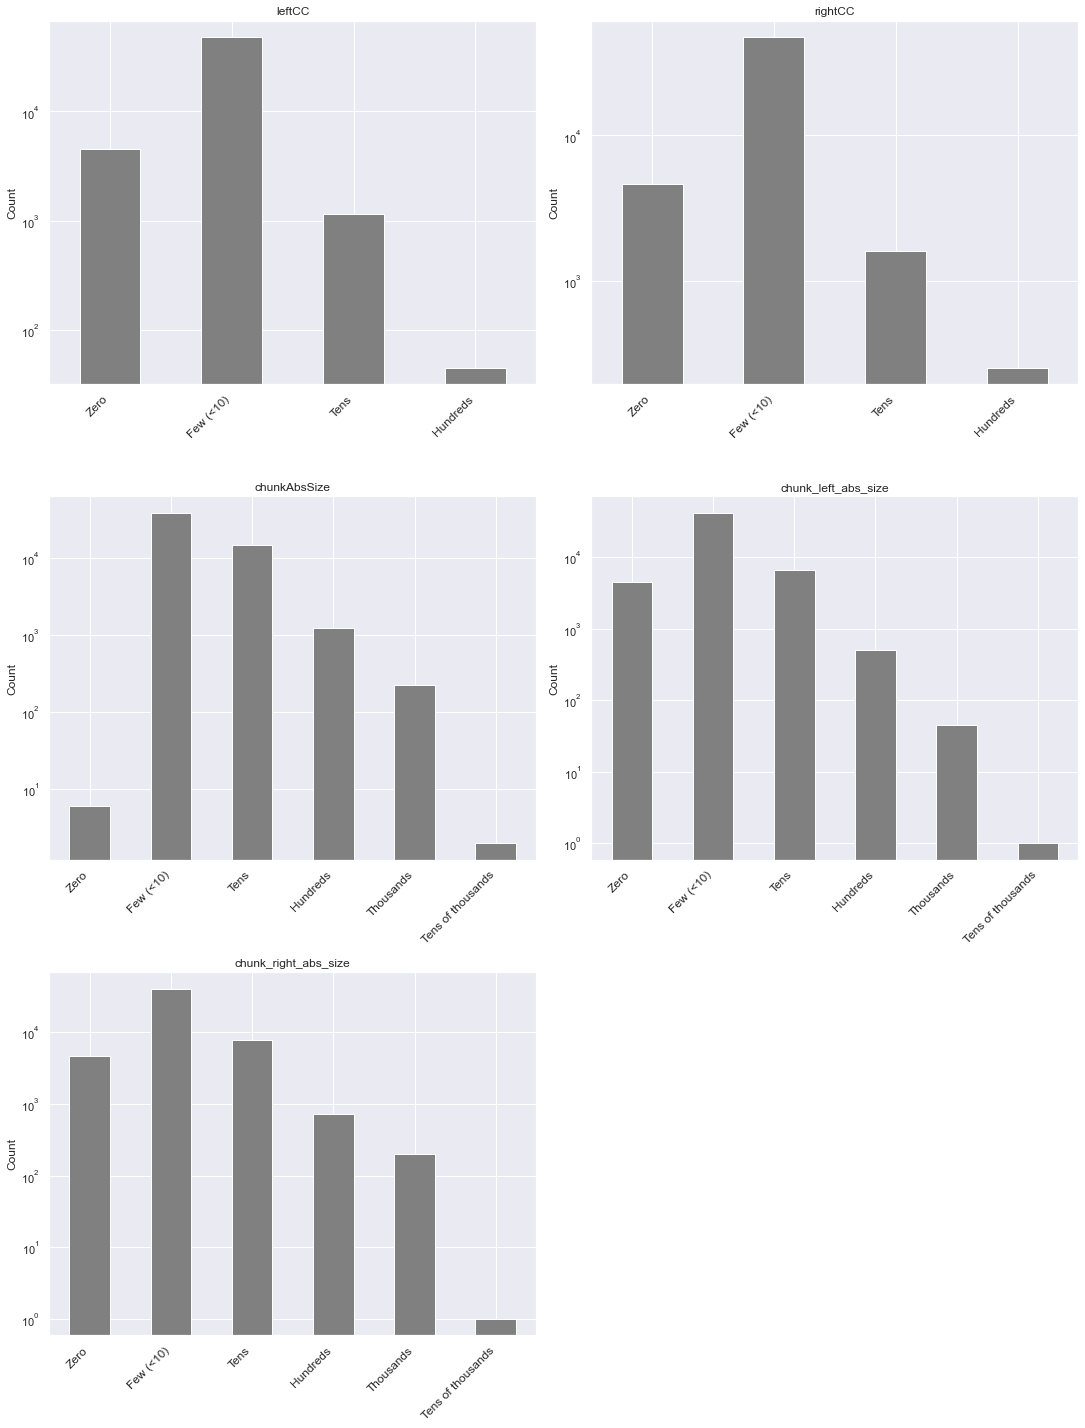

In [26]:
utils_attributes_analysis.count_plot_categorical(chunk_columns_categorical, discretized, labels, 2, True, 10)

### Distribution of chunk continuous attributes <a class="anchor" id="chunk_continuous_distribution"></a>

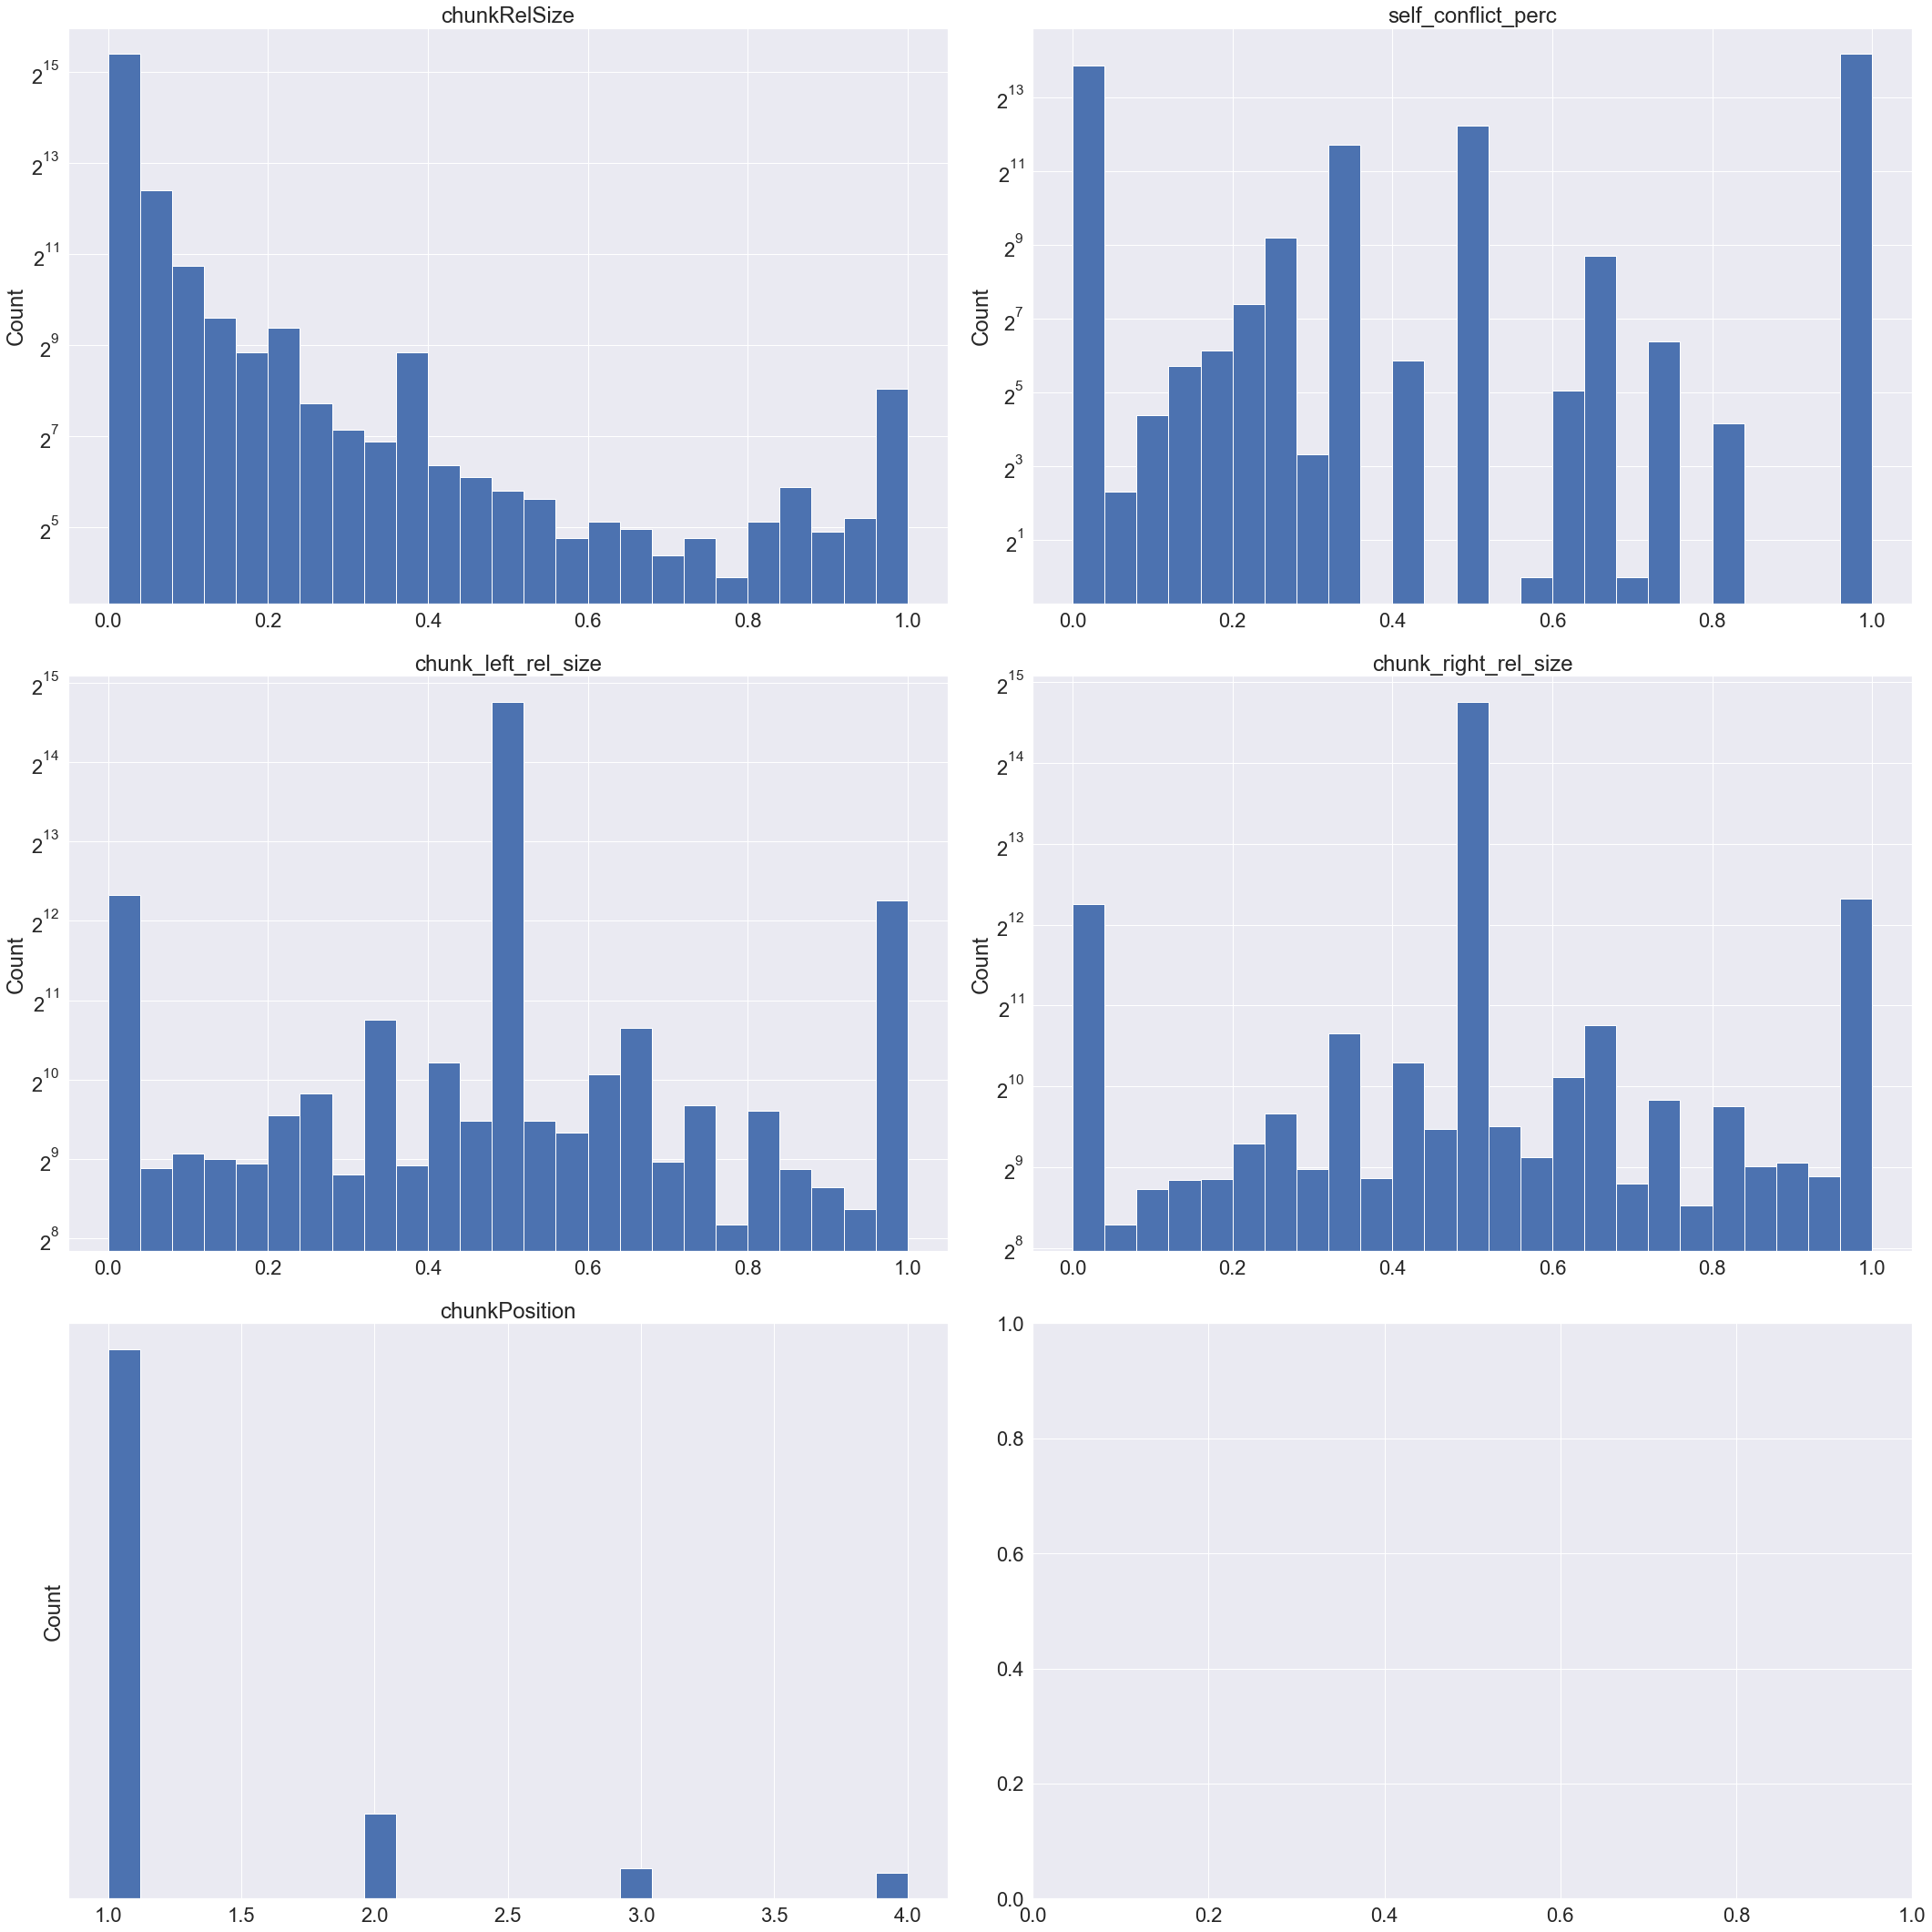

In [27]:
utils_attributes_analysis.hist_plot(chunk_columns_float, df, 2, True, 2)

### Distribution of chunk continuous attributes per developerdecision <a class="anchor" id="chunk_continuous_decision"></a>

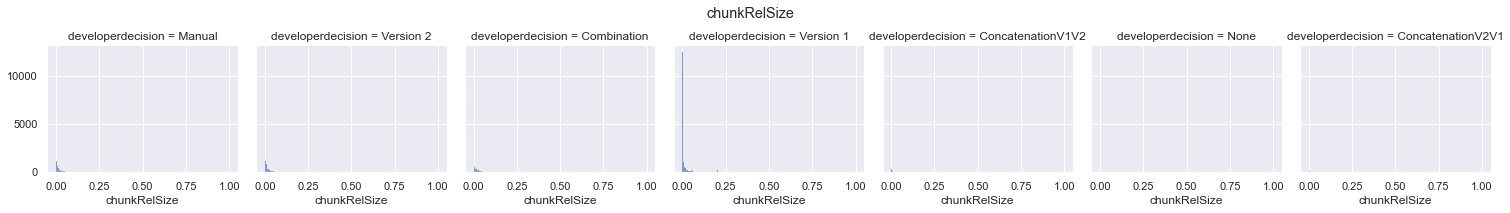

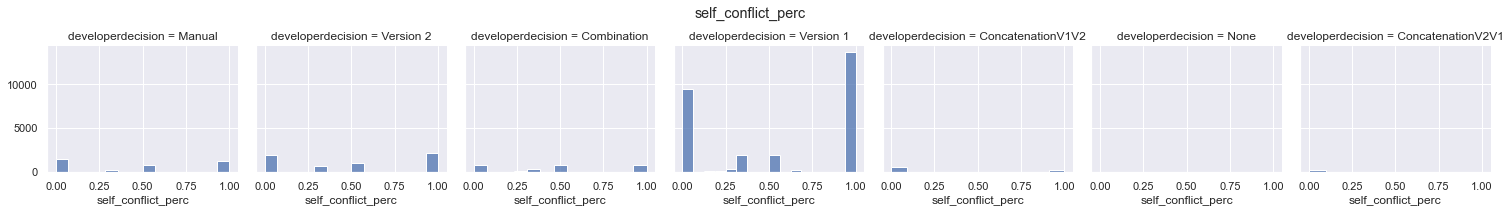

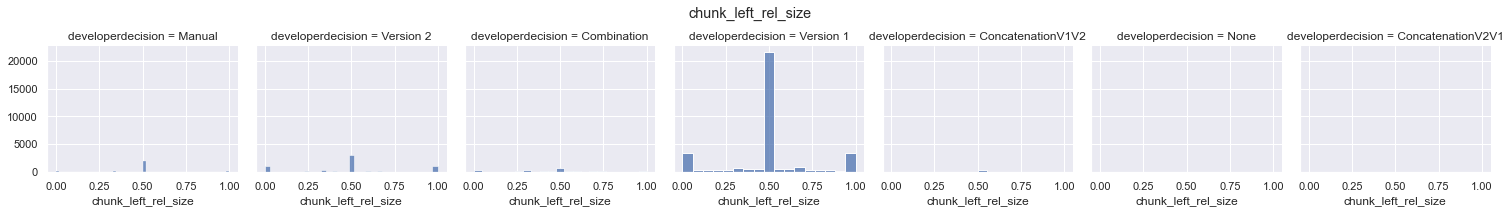

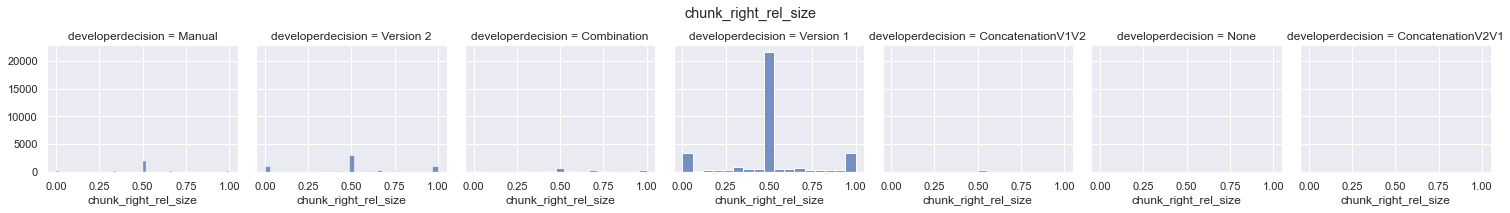

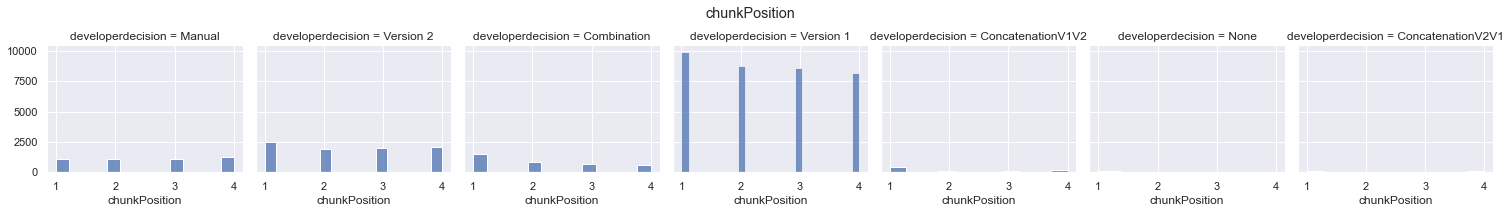

In [28]:
utils_attributes_analysis.hist_plot_by_category(chunk_columns_float, df, 'developerdecision')

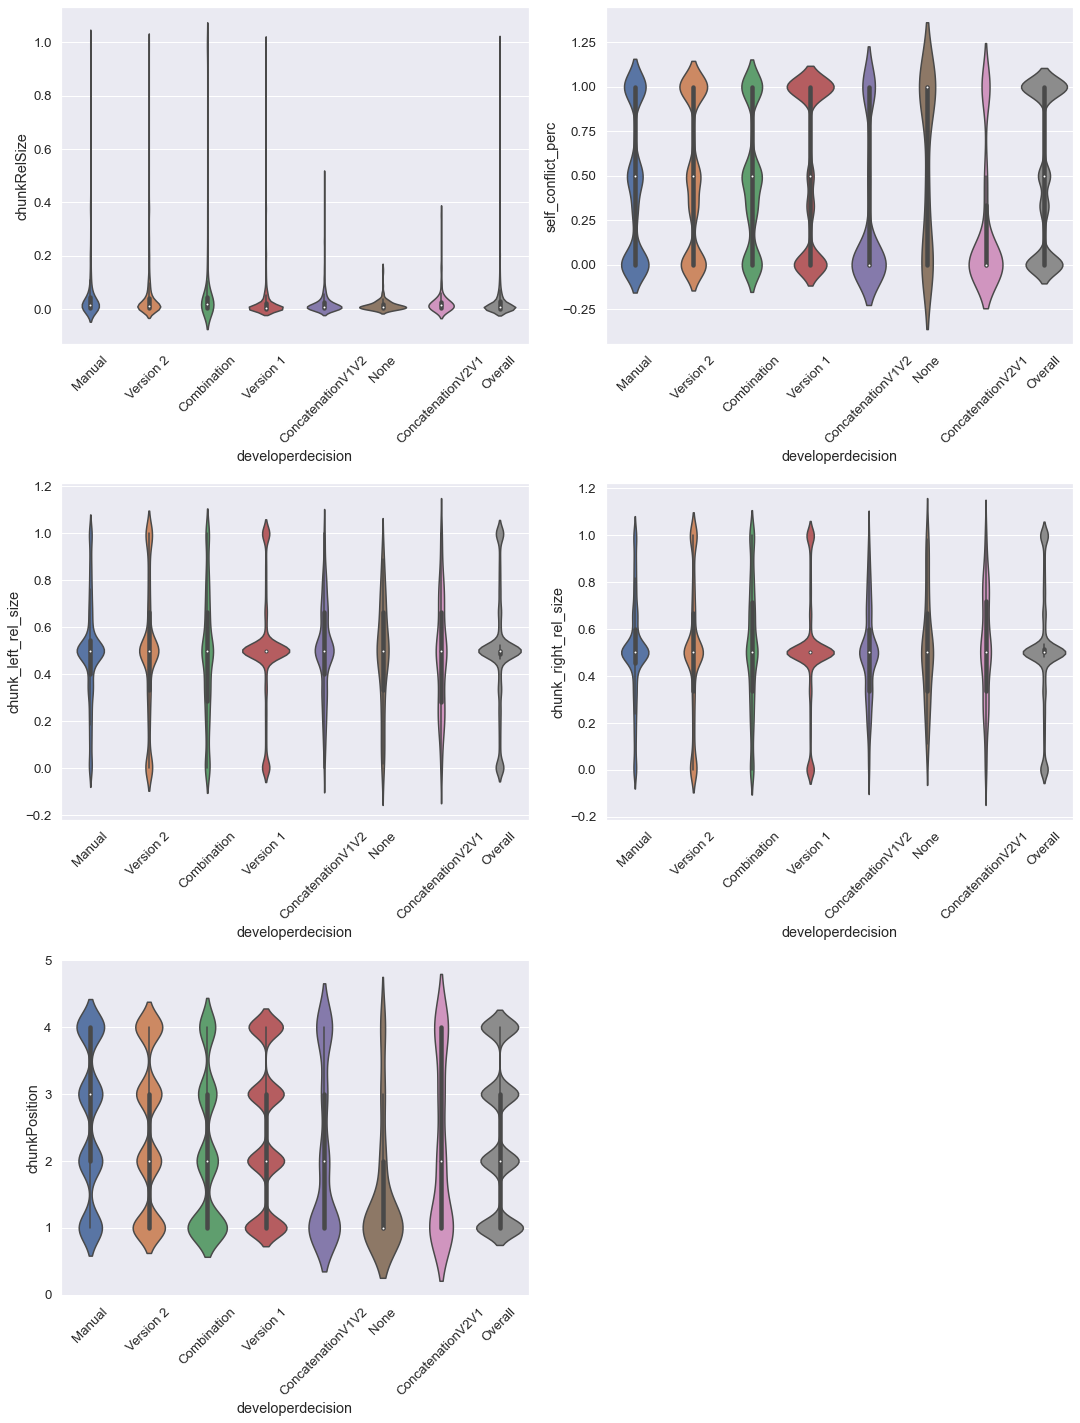

In [29]:
utils_attributes_analysis.violin_by_category(chunk_columns_float, df, 'developerdecision')

### Correlation between chunk continuous attributes and developerdecision <a class="anchor" id="correlation_chunk"></a>

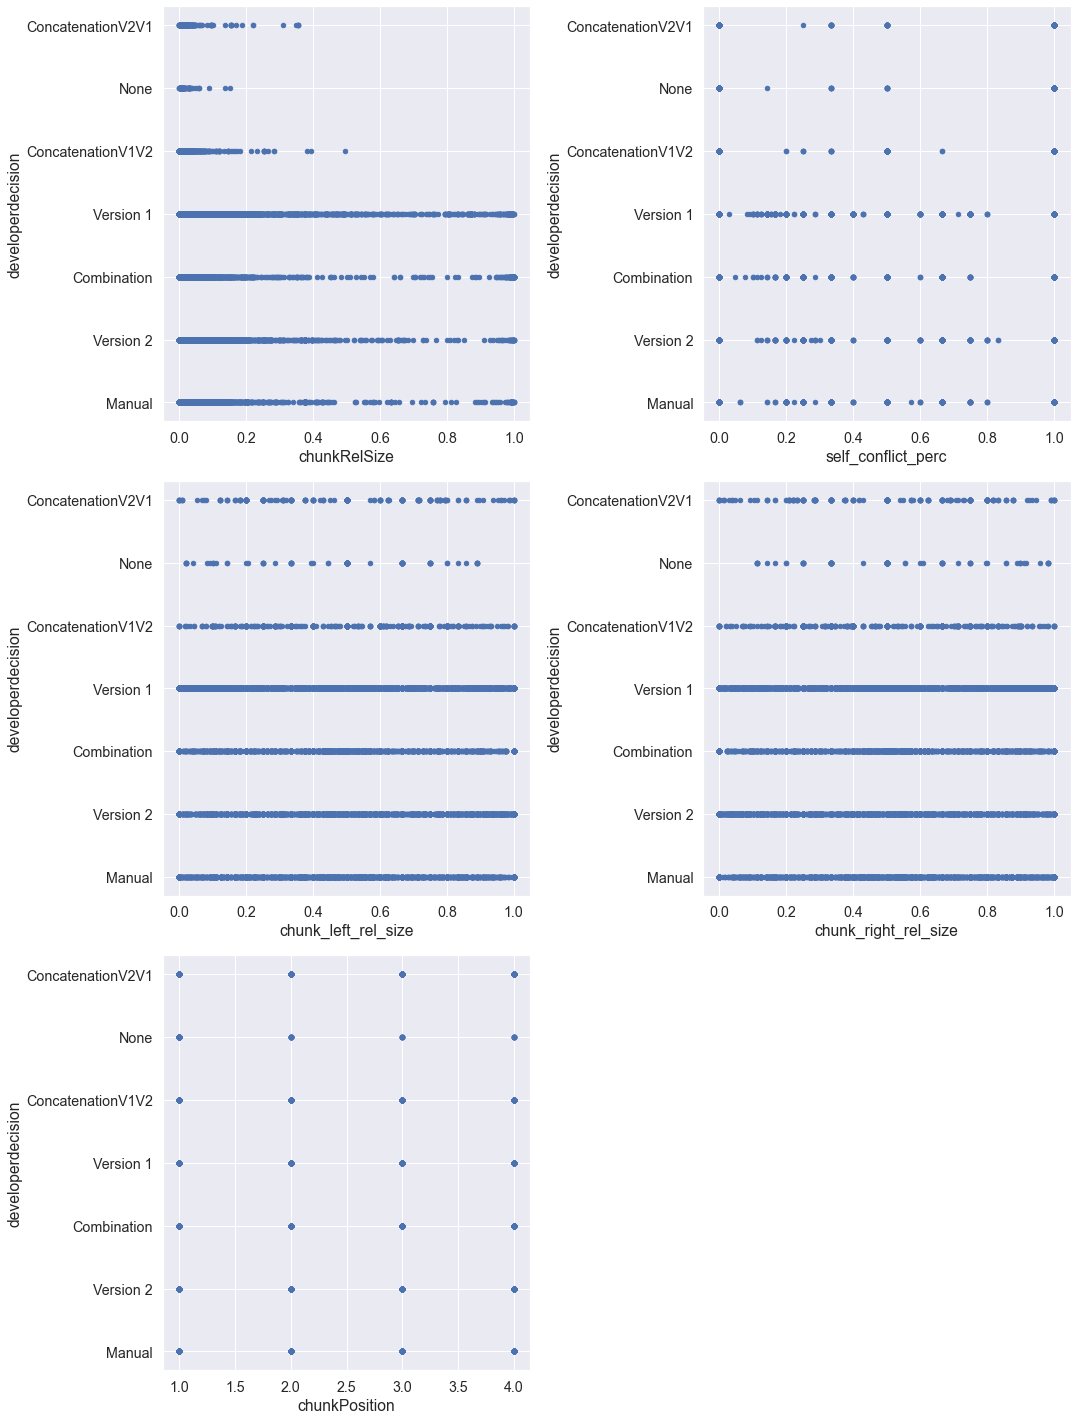

In [30]:
utils_attributes_analysis.scatter_by_category(chunk_columns_float, df, 'developerdecision')

### Probability plots for chunk continuous attributes <a class="anchor" id="chunk_probability"></a>

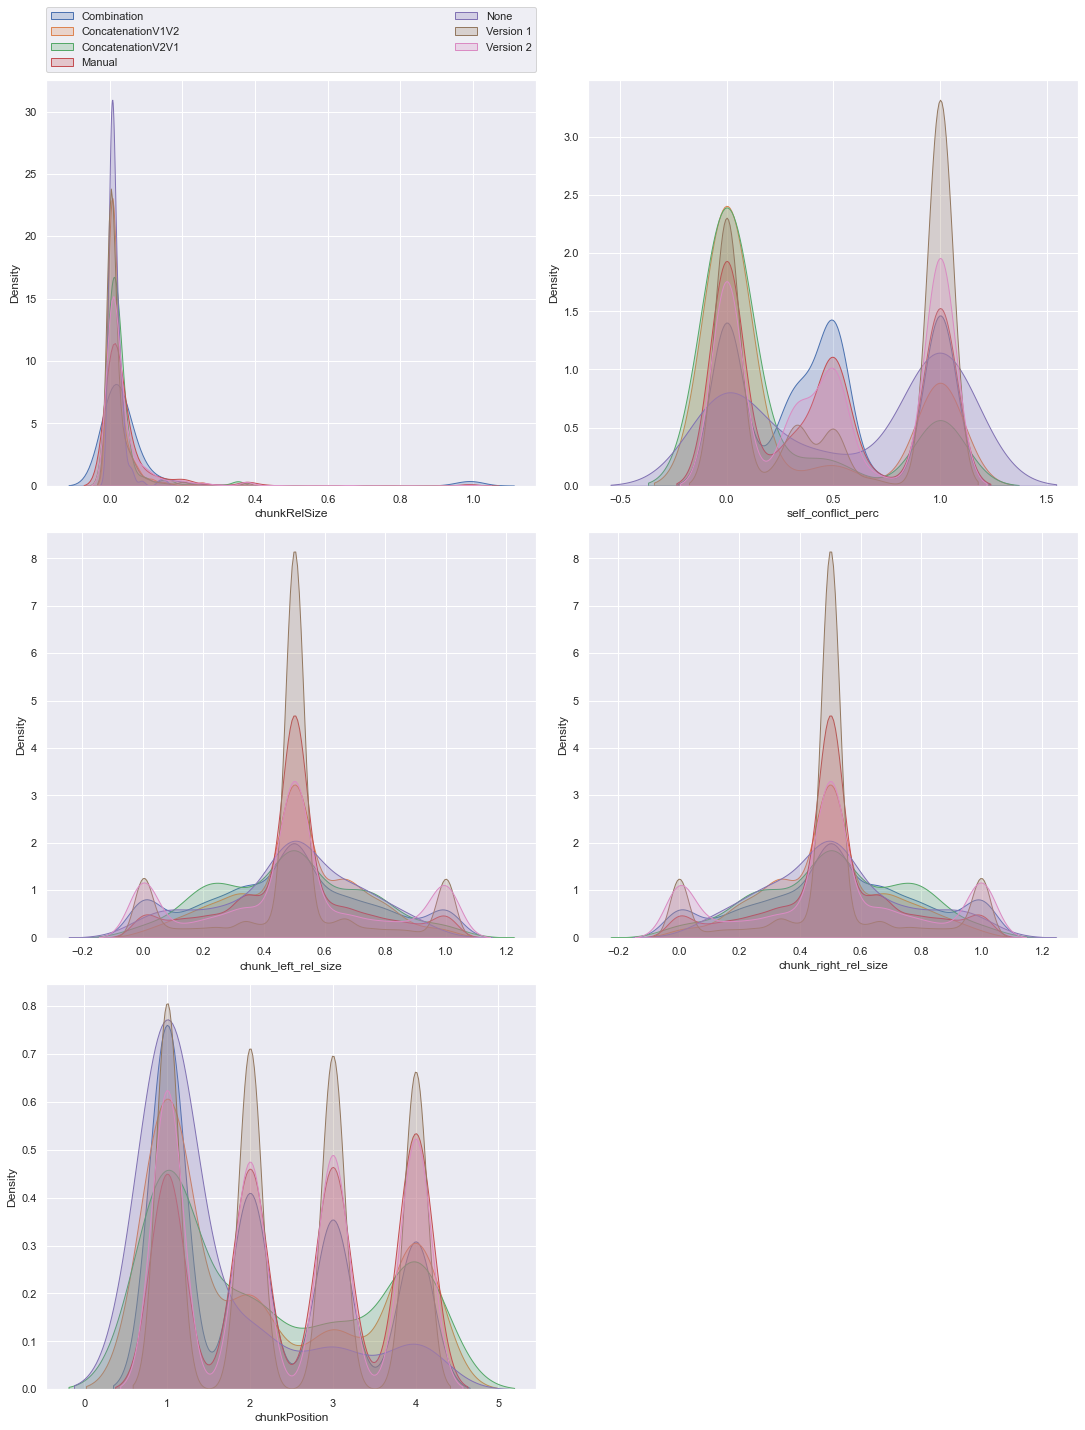

In [31]:
utils_attributes_analysis.density_by_category(chunk_columns_float, df, 'developerdecision', 2)

### Lift analysis for Chunk level attributes <a class="anchor" id="chunk_lift"></a>

In [32]:
all_df_increase = None
all_df_decrease = None
first = True
for file_level_attribute in chunk_columns_categorical:
#     print(f'Lift analysis for {file_level_attribute} attribute:')
    lift, df_confidence, support, df_count = utils.lift_analysis(discretized, file_level_attribute, 'developerdecision')
#     print('Count:')
#     display(df_count)
#     print('Confidence:')
#     display(df_confidence)
#     print('Lift:')
#     display(lift)
    
    threshold = 0.5
    df_increase, df_decrease = utils.get_rules_of_interest(threshold, lift, file_level_attribute, df_confidence, df_count)
    if first:
        all_df_increase = df_increase
        all_df_decrease = df_decrease
        first = False
    else:
        all_df_increase = pd.concat([all_df_increase, df_increase])
        all_df_decrease = pd.concat([all_df_decrease, df_decrease])    

In [33]:
    print(f"Mined rules with at least {threshold*100:.2f}% increased chance")
    display(all_df_increase.sort_values(by=['Lift'], ascending=False))
    
    print(f"Mined rules with at least {threshold*100:.2f}% decreased chance")
    display(all_df_decrease.sort_values(by=['Lift']))

Mined rules with at least 50.00% increased chance


,Rule,Lift,Confidence,Occurrences
0,chunk_right_abs_size=Tens of thousands => Comb...,14.969390,1.000000,1
0,chunk_left_abs_size=Tens of thousands => Combi...,14.969390,1.000000,1
1,chunk_left_abs_size=Thousands => Combination,8.648981,0.577778,26
0,leftCC=Hundreds => Combination,7.983675,0.533333,24
0,chunkAbsSize=Tens of thousands => Combination,7.484695,0.500000,1
1,chunkAbsSize=Tens of thousands => Manual,4.480561,0.500000,1
1,chunk_right_abs_size=Hundreds => None,4.097135,0.008451,6
2,chunk_left_abs_size=Hundreds => Combination,3.749729,0.250493,127
2,chunkAbsSize=Thousands => Combination,2.980631,0.199115,45
2,chunk_right_abs_size=Hundreds => Combination,2.740874,0.183099,130


Mined rules with at least 50.00% decreased chance


,Rule,Lift,Confidence,Occurrences
0,leftCC=Zero => ConcatenationV1V2,0.086810,0.001321,6
0,chunk_left_abs_size=Zero => ConcatenationV1V2,0.086810,0.001321,6
1,chunk_left_abs_size=Hundreds => ConcatenationV1V2,0.129588,0.001972,1
0,rightCC=Zero => ConcatenationV1V2,0.141110,0.002148,10
0,chunk_right_abs_size=Zero => ConcatenationV1V2,0.141110,0.002148,10
1,leftCC=Hundreds => Version 1,0.175916,0.111111,5
1,chunk_right_abs_size=Thousands => Version 2,0.182533,0.030457,6
1,rightCC=Hundreds => Version 2,0.210698,0.035156,9
2,chunk_left_abs_size=Tens => None,0.217282,0.000448,3
2,chunk_right_abs_size=Zero => ConcatenationV2V1,0.220286,0.001289,6


## File attributes <a class="anchor" id="file"></a>

### Distribution of file categorical attributes <a class="anchor" id="file_categorical_distribution"></a>

#### Using log 2 discretization

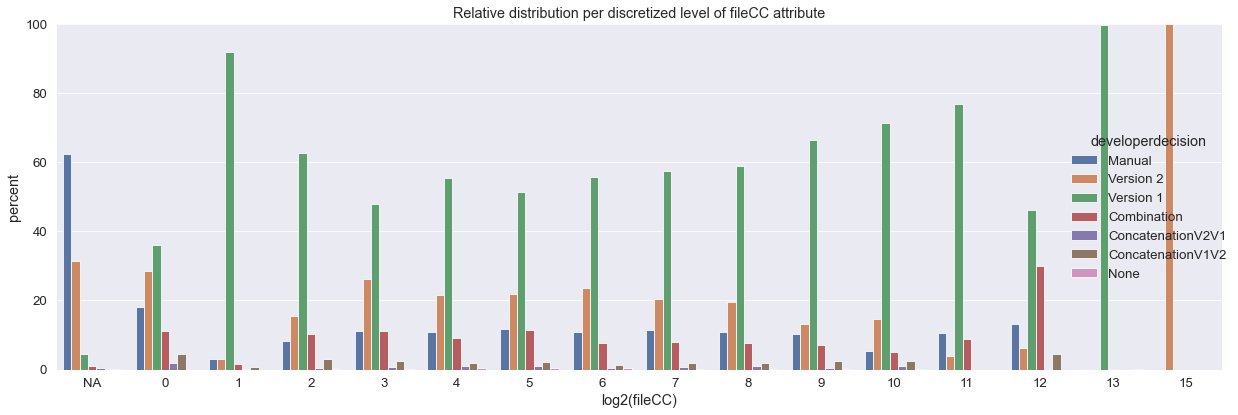

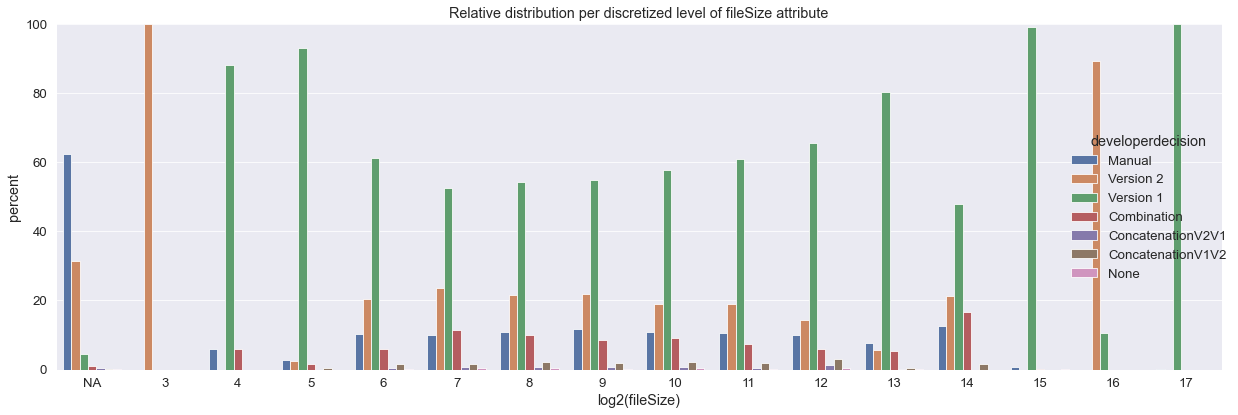

In [34]:
utils_attributes_analysis.relative_percentage_by_group_plot(file_columns_categorical, discretized_log, 'developerdecision', True)

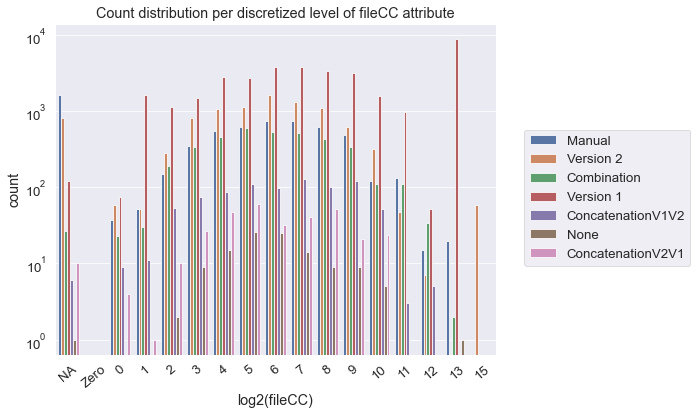

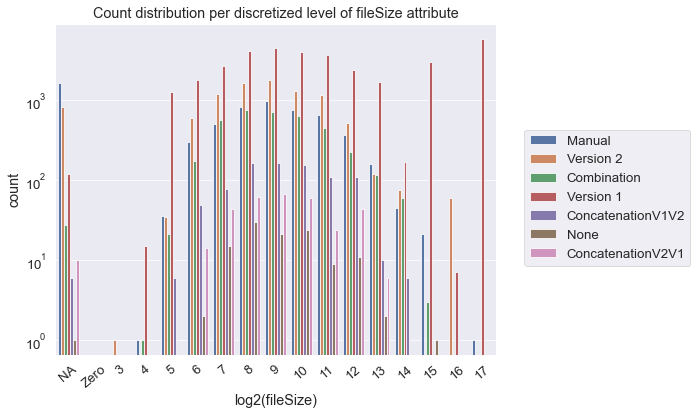

In [35]:
utils_attributes_analysis.count_plot_by_category(file_columns_categorical, discretized_log, 'developerdecision', True)

#### Using log 10 (textual) discretization

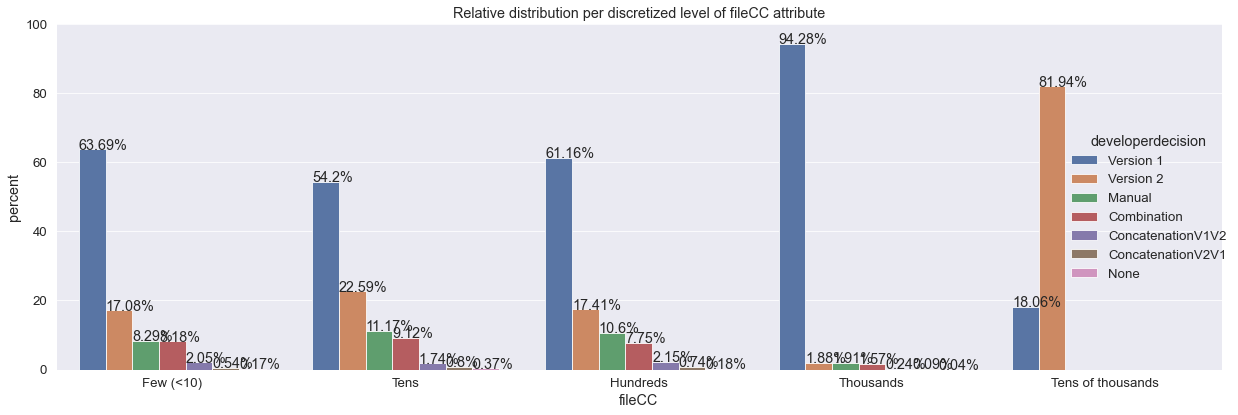

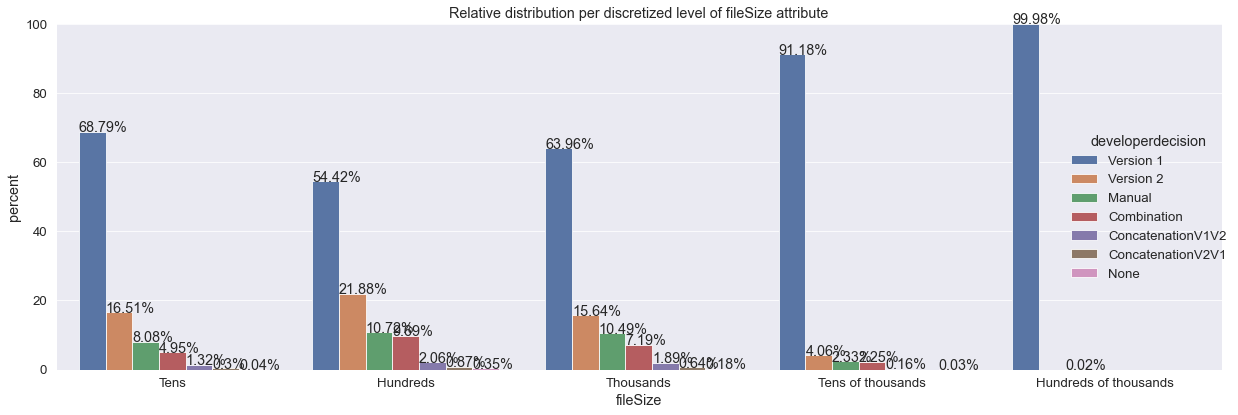

In [36]:
utils_attributes_analysis.relative_percentage_by_group_plot(file_columns_categorical, discretized, 'developerdecision')

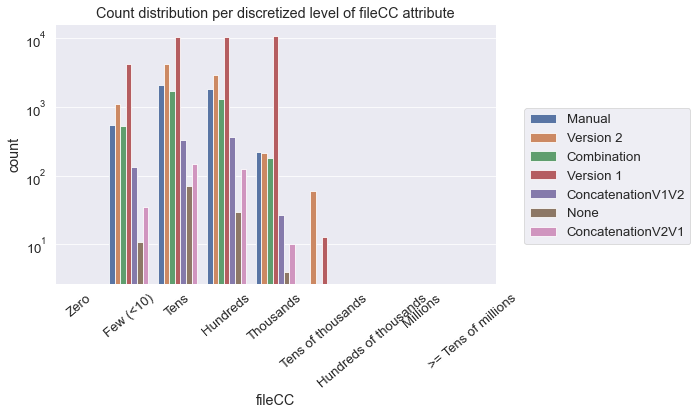

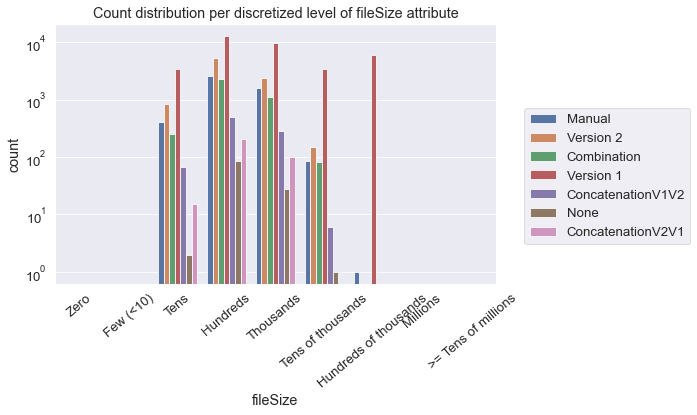

In [37]:
utils_attributes_analysis.count_plot_by_category(file_columns_categorical, discretized, 'developerdecision')

### Lift analysis for File level attributes <a class="anchor" id="file_lift"></a>

In [38]:
all_df_increase = None
all_df_decrease = None
first = True
for file_level_attribute in file_columns_categorical:
#     print(f'Lift analysis for {file_level_attribute} attribute:')
    lift, df_confidence, support, df_count = utils.lift_analysis(discretized, file_level_attribute, 'developerdecision')
#     print('Count:')
#     display(df_count)
#     print('Confidence:')
#     display(df_confidence)
#     print('Lift:')
#     display(lift)
    
    threshold = 0.5
    df_increase, df_decrease = utils.get_rules_of_interest(threshold, lift, file_level_attribute, df_confidence, df_count)
    if first:
        all_df_increase = df_increase
        all_df_decrease = df_decrease
        first = False
    else:
        all_df_increase = pd.concat([all_df_increase, df_increase])
        all_df_decrease = pd.concat([all_df_decrease, df_decrease])  

In [39]:
    print(f"Mined rules with at least {threshold*100:.2f}% increased chance")
    display(all_df_increase.sort_values(by=['Lift'], ascending=False))
    
    print(f"Mined rules with at least {threshold*100:.2f}% decreased chance")
    display(all_df_decrease.sort_values(by=['Lift']))

Mined rules with at least 50.00% increased chance


,Rule,Lift,Confidence,Occurrences
0,fileCC=Tens of thousands => Version 2,4.911078,0.819444,59
1,fileCC=Tens => None,1.807420,0.003728,70
0,fileSize=Hundreds => None,1.715987,0.003539,84
1,fileSize=Hundreds of thousands => Version 1,1.582976,0.999831,5901


Mined rules with at least 50.00% decreased chance


,Rule,Lift,Confidence,Occurrences
0,fileSize=Hundreds of thousands => Manual,0.001518,0.000169,1
1,fileSize=Tens of thousands => ConcatenationV1V2,0.106657,0.001623,6
0,fileCC=Thousands => Version 2,0.112792,0.018820,215
2,fileSize=Tens of thousands => None,0.131176,0.000271,1
1,fileCC=Thousands => ConcatenationV2V1,0.149634,0.000875,10
2,fileCC=Thousands => ConcatenationV1V2,0.155281,0.002363,27
3,fileCC=Thousands => None,0.169758,0.000350,4
4,fileCC=Thousands => Manual,0.171002,0.019083,218
3,fileSize=Tens => None,0.194476,0.000401,2
4,fileSize=Tens of thousands => Manual,0.208511,0.023268,86


## Merge attributes <a class="anchor" id="merge"></a>

### Distribution of merge categorical attributes <a class="anchor" id="merge_categorical_distribution"></a>

In [40]:
merge_columns_categorical_1 = merge_columns_categorical[:len(merge_columns_categorical)//2]
merge_columns_categorical_2 = merge_columns_categorical[len(merge_columns_categorical)//2:]

#### Using log2 discretization

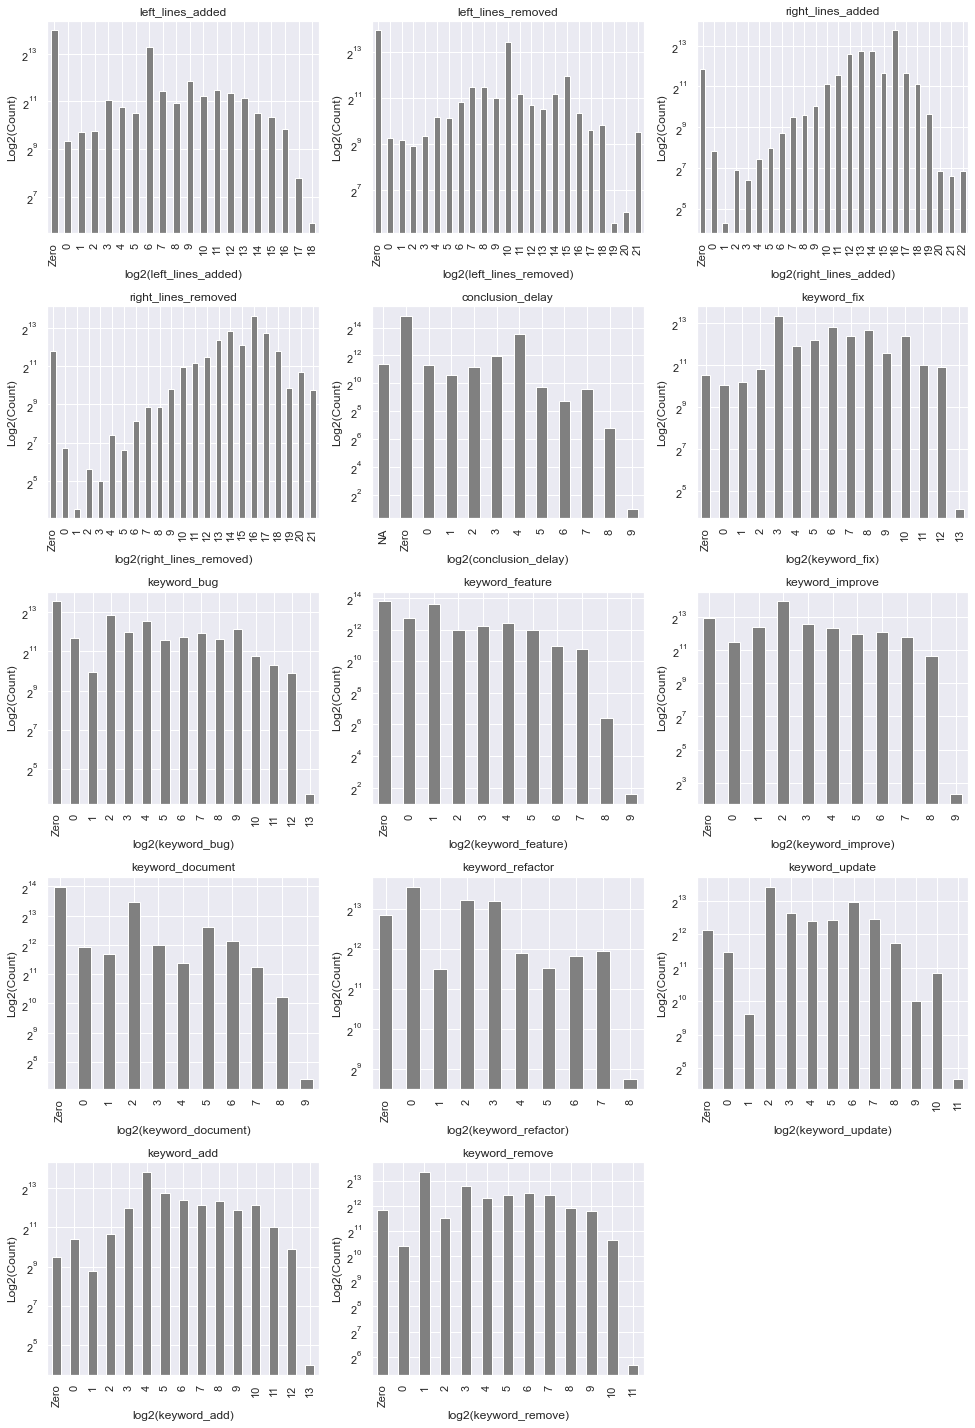

In [41]:
utils_attributes_analysis.count_plot_categorical_new(merge_columns_categorical_1, discretized_log, 3, True, 2)

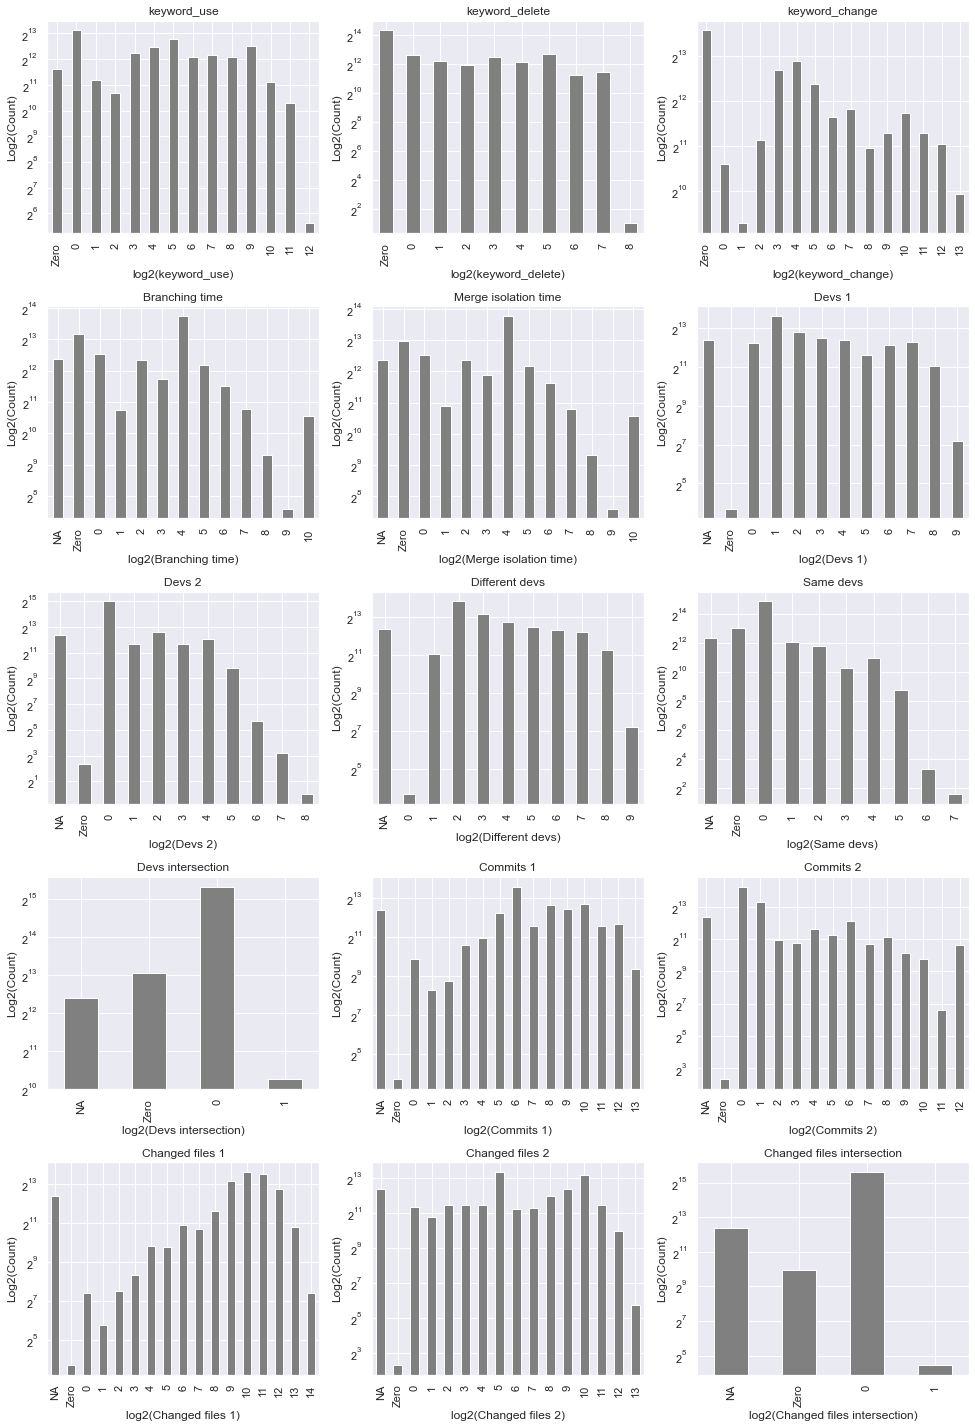

In [42]:
utils_attributes_analysis.count_plot_categorical_new(merge_columns_categorical_2, discretized_log, 3, True, 2)

#### Using log10 (textual) discretization

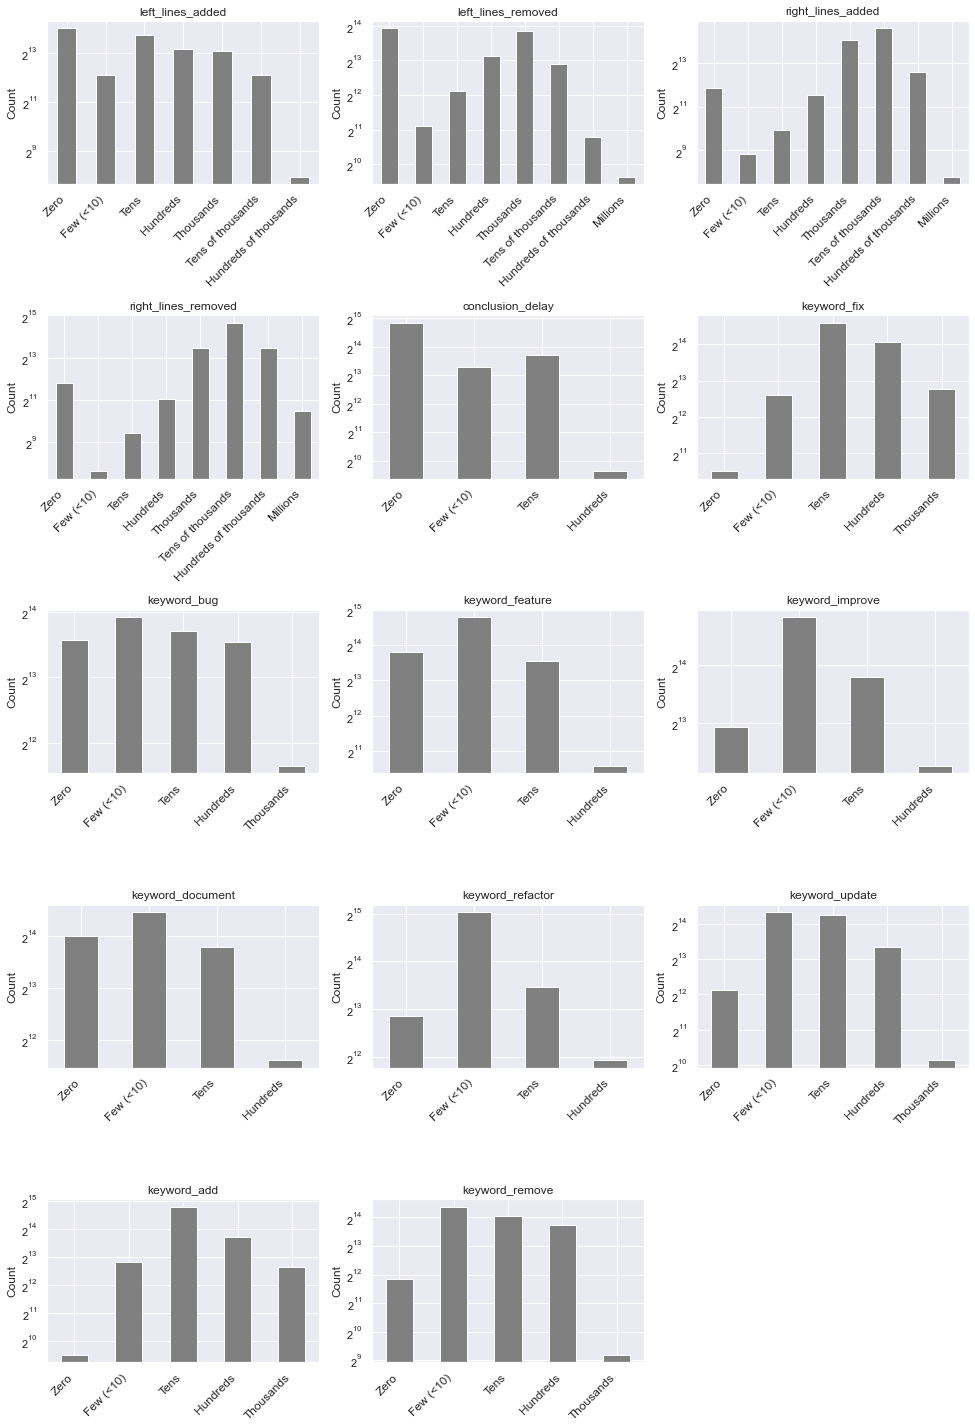

In [43]:
utils_attributes_analysis.count_plot_categorical(merge_columns_categorical_1, discretized, labels, 3, True, 2)

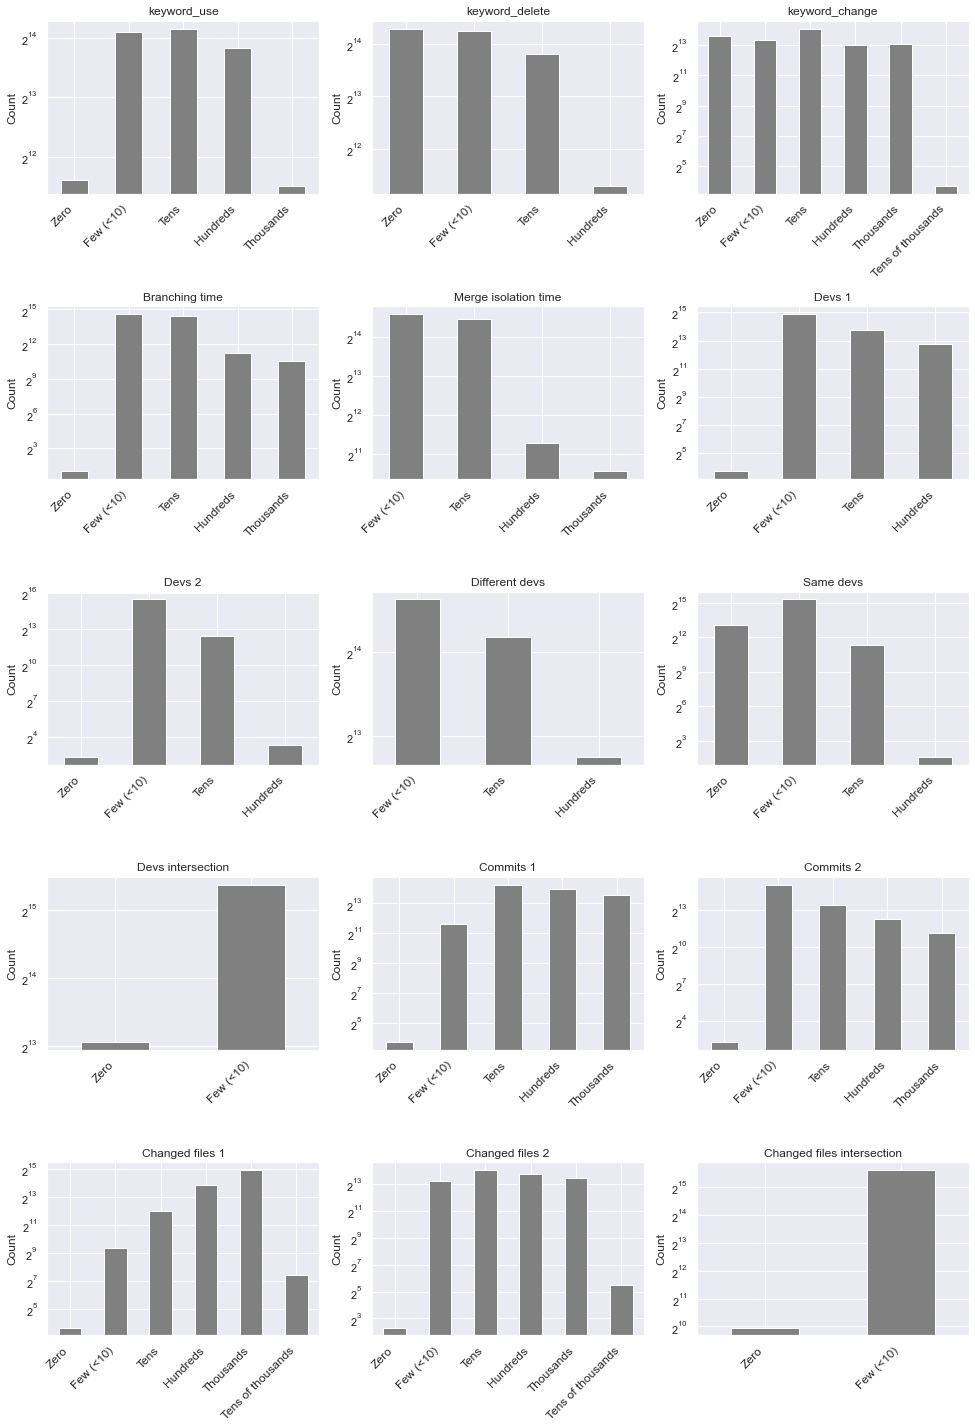

In [44]:
utils_attributes_analysis.count_plot_categorical(merge_columns_categorical_2, discretized, labels, 3, True, 2)

### Lift analysis for Merge level attributes <a class="anchor" id="merge_lift"></a>

In [45]:
all_df_increase = None
all_df_decrease = None
first = True
for file_level_attribute in merge_columns_categorical:
#     print(f'Lift analysis for {file_level_attribute} attribute:')
    lift, df_confidence, support, df_count = utils.lift_analysis(discretized, file_level_attribute, 'developerdecision')
#     print('Count:')
#     display(df_count)
#     print('Confidence:')
#     display(df_confidence)
#     print('Lift:')
#     display(lift)
    
    threshold = 0.5
    df_increase, df_decrease = utils.get_rules_of_interest(threshold, lift, file_level_attribute, df_confidence, df_count)
    if first:
        all_df_increase = df_increase
        all_df_decrease = df_decrease
        first = False
    else:
        all_df_increase = pd.concat([all_df_increase, df_increase])
        all_df_decrease = pd.concat([all_df_decrease, df_decrease])    

In [46]:
    print(f"Mined rules with at least {threshold*100:.2f}% increased chance")
    display(all_df_increase[all_df_increase['Occurrences'] > 3].sort_values(by=['Lift'], ascending=False))
    
    print(f"Mined rules with at least {threshold*100:.2f}% decreased chance")
    display(all_df_decrease[all_df_decrease['Occurrences'] > 3].sort_values(by=['Lift']))

Mined rules with at least 50.00% increased chance


,Rule,Lift,Confidence,Occurrences
0,Changed files 2=Tens of thousands => Version 2,5.856971,0.977273,43
1,Devs 1=Zero => Manual,5.514536,0.615385,8
1,Changed files 1=Zero => Manual,5.514536,0.615385,8
1,Commits 1=Zero => Manual,5.514536,0.615385,8
0,right_lines_removed=Zero => Manual,4.219216,0.470836,1679
...,...,...,...,...
9,Changed files 1=Tens of thousands => Concatena...,1.510366,0.022989,4
12,right_lines_removed=Thousands => Combination,1.510296,0.100892,1142
11,left_lines_removed=Millions => Version 1,1.509651,0.953518,759
12,left_lines_removed=Hundreds => ConcatenationV1V2,1.505934,0.022921,207


Mined rules with at least 50.00% decreased chance


,Rule,Lift,Confidence,Occurrences
0,left_lines_removed=Zero => ConcatenationV1V2,0.029368,0.000447,7
1,left_lines_removed=Zero => Combination,0.064045,0.004278,67
1,Changed files 2=Thousands => ConcatenationV2V1,0.091633,0.000536,6
1,right_lines_added=Zero => ConcatenationV1V2,0.106112,0.001615,6
0,right_lines_removed=Zero => ConcatenationV1V2,0.110546,0.001683,6
...,...,...,...,...
5,Branching time=Hundreds => Combination,0.488872,0.032658,79
10,right_lines_added=Hundreds of thousands => Ver...,0.489063,0.081603,511
13,right_lines_removed=Tens of thousands => Conca...,0.497813,0.002912,75
1,Commits 2=Thousands => Combination,0.498297,0.033288,73
